# Vision Transformer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.nn import functional as F
from einops import rearrange, repeat
from tqdm import tqdm
import wandb

## Dataset

In [9]:
# download cifar10 dataset
transforms_def = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transforms_def)
testset = CIFAR10(root='./data', train=False, download=True, transform=transforms_def)

# split train to train and val
# trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

print("Training data:", len(trainset))
# print("Validation data:", len(valset))
print("Test data:", len(testset))

Training data: 50000
Test data: 10000


In [10]:
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

In [11]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
# val_loader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=8)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)

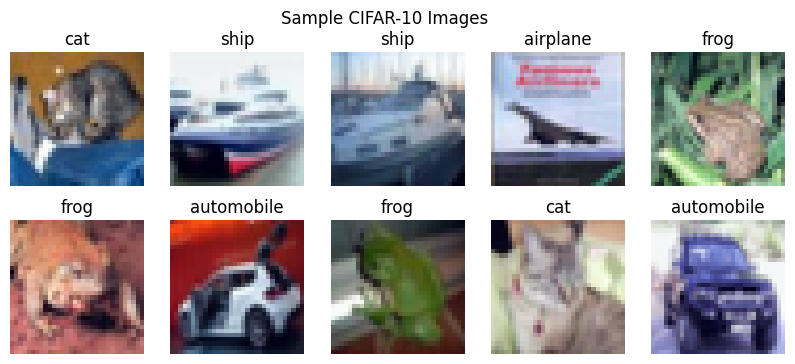

In [5]:
# visualize some data
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    img = testset[i][0].permute(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(cifar10_classes[testset[i][1]])
plt.suptitle('Sample CIFAR-10 Images')
plt.show()


## Model

In [4]:
# scaled dot product attention
class ScalarDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super(ScalarDotProductAttention, self).__init__()
        self.d_k = d_k # hidden dimension. generally D/k
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, q, k, v, mask=None):
        # q, k, v are of shape (batch_size, num_heads, seq_len, d_k)
        scores = torch.matmul(q, k.transpose(-2, -1)) / self.d_k**0.5
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = self.softmax(scores)
        output = torch.matmul(attn, v)
        return output, attn
    
# multi head attention
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, embedding_dim, dropout=0.0):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.d_k = embedding_dim // num_heads
        
        self.query = nn.Linear(embedding_dim, embedding_dim)
        self.key = nn.Linear(embedding_dim, embedding_dim)
        self.value = nn.Linear(embedding_dim, embedding_dim)
        self.scalar_dot_product_attention = ScalarDotProductAttention(self.d_k)
        self.fc = nn.Linear(embedding_dim, embedding_dim) # U_msa in paper
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, embedding_dim = x.size()
        
        q = self.query(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        k = self.key(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        v = self.value(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        attn_output, scores = self.scalar_dot_product_attention(q, k, v, mask)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embedding_dim)
        output = self.fc(attn_output)
        output = self.dropout(output)
        return output, scores
    
# mlp layer
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.0):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x
    
# transformer encoder
class TransformerEncoderLayer(nn.Module):
    def __init__(self, input_dim, num_heads, hidden_dim, dropout=0.0):
        super(TransformerEncoderLayer, self).__init__()
        self.norm1 = nn.LayerNorm(input_dim)
        self.mha = MultiHeadAttention(num_heads, input_dim, dropout)
        self.norm2 = nn.LayerNorm(input_dim)
        self.mlp = MLP(input_dim, hidden_dim, input_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        self.attention_map = None
        
    def forward(self, x, mask=None):
        attn_output, attn_weights = self.mha(self.norm1(x), mask)
        self.attention_map = attn_weights
        x = x + self.dropout(attn_output)
        mlp_output = self.norm2(x)
        mlp_output = self.mlp(mlp_output)
        x = x + mlp_output
        return x

In [5]:
# vit
class VisionTransformer(nn.Module):
    def __init__(self, embedding_dim, num_heads, mlp_dim, num_encoders, patch_size=4, postional_embedding_type='1D', dropout=0.0):
        super(VisionTransformer, self).__init__()
        self.num_patches = (32 // patch_size) ** 2
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.patch_size = patch_size
        self.position_embedding_type = postional_embedding_type
        self.grid_size = 32 // patch_size
        
        
        self.patch_embedding = nn.Linear(3 * patch_size * patch_size, embedding_dim)
        match postional_embedding_type:
            case '1D':
                self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dim))
            case '2D':
                self.position_embedding_x = nn.Parameter(torch.randn(self.grid_size, embedding_dim // 2))
                self.position_embedding_y = nn.Parameter(torch.randn(self.grid_size, embedding_dim // 2))
            case 'sin':
                self.position_embedding = self._build_sinusoidal_positional_embedding(self.num_patches + 1, embedding_dim)
            case 'none':
                self.position_embedding = None

        # cls token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.dropout = nn.Dropout(dropout)
        
        self.transformer_encoder = nn.ModuleList([
            TransformerEncoderLayer(embedding_dim, num_heads, mlp_dim, dropout)
            for _ in range(num_encoders)
        ])
        self.norm = nn.LayerNorm(embedding_dim)
        self.head = nn.Linear(embedding_dim, 10)
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
    
    def _build_sinusoidal_positional_embedding(self, seq_len, embed_dim):
        pos = torch.arange(seq_len)[:, None]
        i = torch.arange(embed_dim // 2)[None, :]
        angle_rates = 1 / (10000 ** (2 * i / embed_dim))
        angle_rads = pos * angle_rates
        pos_embedding = torch.zeros(seq_len, embed_dim)
        pos_embedding[:, 0::2] = torch.sin(angle_rads)
        pos_embedding[:, 1::2] = torch.cos(angle_rads)
        return nn.Parameter(pos_embedding.unsqueeze(0), requires_grad=False)
        
    def forward(self, x):
        # patches = rearrange(x, 'b c (h ph) (w pw) -> b (h w) (ph pw c)', ph=self.patch_size, pw=self.patch_size)
        patches = self.unfold(x)  # shape: (B, C*patch_size*patch_size, N)
        patches = patches.transpose(1, 2)  # (B, N, patch_dim)
        patches = self.patch_embedding(patches)
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=x.size(0))
        x = torch.cat((cls_tokens, patches), dim=1)
        if self.position_embedding_type != "none":
            if self.position_embedding_type == '2D':
                _y, _x = torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size))
                x_pos = self.position_embedding_x[_x]
                y_pos = self.position_embedding_y[_y]
                pos_embedding = torch.cat((x_pos, y_pos), dim=-1).to(x.device)
                pos_embedding = pos_embedding.reshape(1, self.num_patches, self.embedding_dim).repeat(x.size(0), 1, 1)
                cls_pos = torch.zeros(x.size(0), 1, self.embedding_dim).to(x.device)
                pos_embedding = torch.cat((cls_pos, pos_embedding), dim=1)
                x = x + pos_embedding
            else:
                x = x + self.position_embedding
        for encoder in self.transformer_encoder:
            x = encoder(x)
        x = self.norm(x[:, 0])
        x = self.head(x)
        return x

### Sample Run

In [6]:
def train_model(model, train_loader, val_loader, num_epochs=50, log_wandb=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    # warmup type scheduler
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=num_epochs)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(tqdm(train_loader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Validate the model
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {100 * val_correct / val_total:.2f}%')
        
        if log_wandb:
            wandb.log({
                'train_loss': running_loss / len(train_loader),
                'train_accuracy': 100 * correct / total,
                'val_loss': val_loss / len(val_loader),
                'val_accuracy': 100 * val_correct / val_total
            })
        
        # scheduler.step()
        
def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Loss: {running_loss/len(data_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

In [9]:
wandb.finish()
wandb.init(project='vit-cifar10', name="test")
model = VisionTransformer(
    patch_size=4,
    embedding_dim=96, 
    num_heads=4, 
    postional_embedding_type='1D',
    mlp_dim=192, 
    num_encoders=6, 
    dropout=0.2
)
train_model(model, train_loader, test_loader, num_epochs=50, log_wandb=True)
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: gauravbehera (gauravbehera-iiith) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 782/782 [00:28<00:00, 27.64it/s]


Epoch [1/50], Loss: 1.6595, Accuracy: 39.36%
Validation Loss: 1.4983, Validation Accuracy: 45.91%


100%|██████████| 782/782 [00:24<00:00, 31.47it/s]


Epoch [2/50], Loss: 1.3863, Accuracy: 49.92%
Validation Loss: 1.3169, Validation Accuracy: 52.96%


100%|██████████| 782/782 [00:24<00:00, 31.64it/s]


Epoch [3/50], Loss: 1.2808, Accuracy: 53.78%
Validation Loss: 1.2486, Validation Accuracy: 55.79%


100%|██████████| 782/782 [00:24<00:00, 31.31it/s]


Epoch [4/50], Loss: 1.2098, Accuracy: 56.32%
Validation Loss: 1.2545, Validation Accuracy: 56.30%


100%|██████████| 782/782 [00:24<00:00, 31.70it/s]


Epoch [5/50], Loss: 1.1531, Accuracy: 58.39%
Validation Loss: 1.1636, Validation Accuracy: 58.23%


100%|██████████| 782/782 [00:23<00:00, 32.70it/s]


Epoch [6/50], Loss: 1.0995, Accuracy: 60.51%
Validation Loss: 1.1506, Validation Accuracy: 59.34%


100%|██████████| 782/782 [00:24<00:00, 31.83it/s]


Epoch [7/50], Loss: 1.0572, Accuracy: 62.07%
Validation Loss: 1.1318, Validation Accuracy: 60.61%


100%|██████████| 782/782 [00:24<00:00, 32.05it/s]


Epoch [8/50], Loss: 1.0172, Accuracy: 63.29%
Validation Loss: 1.1426, Validation Accuracy: 60.16%


100%|██████████| 782/782 [00:24<00:00, 32.15it/s]


Epoch [9/50], Loss: 0.9765, Accuracy: 65.23%
Validation Loss: 1.0498, Validation Accuracy: 63.66%


100%|██████████| 782/782 [00:24<00:00, 32.02it/s]


Epoch [10/50], Loss: 0.9427, Accuracy: 66.22%
Validation Loss: 1.0387, Validation Accuracy: 63.93%


100%|██████████| 782/782 [00:24<00:00, 32.01it/s]


Epoch [11/50], Loss: 0.9082, Accuracy: 67.59%
Validation Loss: 1.0532, Validation Accuracy: 64.02%


100%|██████████| 782/782 [00:23<00:00, 32.94it/s]


Epoch [12/50], Loss: 0.8766, Accuracy: 68.75%
Validation Loss: 1.0324, Validation Accuracy: 64.52%


100%|██████████| 782/782 [00:23<00:00, 33.88it/s]


Epoch [13/50], Loss: 0.8443, Accuracy: 69.83%
Validation Loss: 1.0262, Validation Accuracy: 65.25%


100%|██████████| 782/782 [00:23<00:00, 33.13it/s]


Epoch [14/50], Loss: 0.8176, Accuracy: 70.84%
Validation Loss: 1.0031, Validation Accuracy: 66.00%


100%|██████████| 782/782 [00:23<00:00, 32.75it/s]


Epoch [15/50], Loss: 0.7917, Accuracy: 71.70%
Validation Loss: 1.0027, Validation Accuracy: 66.48%


100%|██████████| 782/782 [00:24<00:00, 32.53it/s]


Epoch [16/50], Loss: 0.7609, Accuracy: 72.84%
Validation Loss: 0.9915, Validation Accuracy: 66.07%


100%|██████████| 782/782 [00:24<00:00, 32.49it/s]


Epoch [17/50], Loss: 0.7332, Accuracy: 73.68%
Validation Loss: 0.9685, Validation Accuracy: 67.95%


100%|██████████| 782/782 [00:23<00:00, 33.14it/s]


Epoch [18/50], Loss: 0.7055, Accuracy: 74.90%
Validation Loss: 0.9994, Validation Accuracy: 67.63%


100%|██████████| 782/782 [00:23<00:00, 33.74it/s]


Epoch [19/50], Loss: 0.6846, Accuracy: 75.35%
Validation Loss: 0.9820, Validation Accuracy: 67.26%


100%|██████████| 782/782 [00:23<00:00, 32.75it/s]


Epoch [20/50], Loss: 0.6646, Accuracy: 76.27%
Validation Loss: 0.9877, Validation Accuracy: 67.79%


100%|██████████| 782/782 [00:23<00:00, 33.29it/s]


Epoch [21/50], Loss: 0.6356, Accuracy: 77.25%
Validation Loss: 0.9850, Validation Accuracy: 68.83%


100%|██████████| 782/782 [00:23<00:00, 33.21it/s]


Epoch [22/50], Loss: 0.6126, Accuracy: 78.24%
Validation Loss: 0.9744, Validation Accuracy: 68.98%


100%|██████████| 782/782 [00:23<00:00, 33.20it/s]


Epoch [23/50], Loss: 0.5923, Accuracy: 78.79%
Validation Loss: 1.0196, Validation Accuracy: 68.88%


100%|██████████| 782/782 [00:23<00:00, 33.33it/s]


Epoch [24/50], Loss: 0.5724, Accuracy: 79.61%
Validation Loss: 0.9900, Validation Accuracy: 69.19%


100%|██████████| 782/782 [00:23<00:00, 32.83it/s]


Epoch [25/50], Loss: 0.5469, Accuracy: 80.22%
Validation Loss: 1.0173, Validation Accuracy: 68.81%


100%|██████████| 782/782 [00:23<00:00, 33.75it/s]


Epoch [26/50], Loss: 0.5270, Accuracy: 81.16%
Validation Loss: 1.0603, Validation Accuracy: 68.49%


100%|██████████| 782/782 [00:23<00:00, 33.25it/s]


Epoch [27/50], Loss: 0.5087, Accuracy: 81.59%
Validation Loss: 1.0579, Validation Accuracy: 69.39%


100%|██████████| 782/782 [00:23<00:00, 33.65it/s]


Epoch [28/50], Loss: 0.4872, Accuracy: 82.40%
Validation Loss: 1.0416, Validation Accuracy: 69.93%


100%|██████████| 782/782 [00:23<00:00, 33.22it/s]


Epoch [29/50], Loss: 0.4663, Accuracy: 83.33%
Validation Loss: 1.0845, Validation Accuracy: 69.78%


100%|██████████| 782/782 [00:23<00:00, 33.09it/s]


Epoch [30/50], Loss: 0.4544, Accuracy: 83.81%
Validation Loss: 1.0798, Validation Accuracy: 69.66%


100%|██████████| 782/782 [00:23<00:00, 32.97it/s]


Epoch [31/50], Loss: 0.4329, Accuracy: 84.55%
Validation Loss: 1.1269, Validation Accuracy: 69.54%


100%|██████████| 782/782 [00:23<00:00, 33.29it/s]


Epoch [32/50], Loss: 0.4143, Accuracy: 85.07%
Validation Loss: 1.1090, Validation Accuracy: 70.25%


100%|██████████| 782/782 [00:23<00:00, 33.72it/s]


Epoch [33/50], Loss: 0.3977, Accuracy: 85.71%
Validation Loss: 1.1524, Validation Accuracy: 69.58%


100%|██████████| 782/782 [00:23<00:00, 33.71it/s]


Epoch [34/50], Loss: 0.3807, Accuracy: 86.39%
Validation Loss: 1.1386, Validation Accuracy: 70.06%


100%|██████████| 782/782 [00:23<00:00, 33.02it/s]


Epoch [35/50], Loss: 0.3701, Accuracy: 86.65%
Validation Loss: 1.1551, Validation Accuracy: 70.33%


100%|██████████| 782/782 [00:23<00:00, 32.82it/s]


Epoch [36/50], Loss: 0.3540, Accuracy: 87.28%
Validation Loss: 1.1642, Validation Accuracy: 69.79%


100%|██████████| 782/782 [00:22<00:00, 34.05it/s]


Epoch [37/50], Loss: 0.3383, Accuracy: 87.85%
Validation Loss: 1.2070, Validation Accuracy: 69.98%


100%|██████████| 782/782 [00:23<00:00, 33.81it/s]


Epoch [38/50], Loss: 0.3220, Accuracy: 88.38%
Validation Loss: 1.2269, Validation Accuracy: 70.29%


100%|██████████| 782/782 [00:23<00:00, 32.98it/s]


Epoch [39/50], Loss: 0.3111, Accuracy: 88.83%
Validation Loss: 1.2637, Validation Accuracy: 69.65%


100%|██████████| 782/782 [00:23<00:00, 33.03it/s]


Epoch [40/50], Loss: 0.3050, Accuracy: 88.94%
Validation Loss: 1.2493, Validation Accuracy: 69.82%


100%|██████████| 782/782 [00:27<00:00, 28.74it/s]


Epoch [41/50], Loss: 0.2934, Accuracy: 89.34%
Validation Loss: 1.2521, Validation Accuracy: 70.16%


100%|██████████| 782/782 [00:27<00:00, 27.95it/s]


Epoch [42/50], Loss: 0.2849, Accuracy: 89.65%
Validation Loss: 1.2677, Validation Accuracy: 70.23%


100%|██████████| 782/782 [00:27<00:00, 28.08it/s]


Epoch [43/50], Loss: 0.2804, Accuracy: 90.01%
Validation Loss: 1.2784, Validation Accuracy: 70.51%


100%|██████████| 782/782 [00:27<00:00, 28.12it/s]


Epoch [44/50], Loss: 0.2750, Accuracy: 90.21%
Validation Loss: 1.2698, Validation Accuracy: 70.49%


100%|██████████| 782/782 [00:28<00:00, 27.75it/s]


Epoch [45/50], Loss: 0.2659, Accuracy: 90.40%
Validation Loss: 1.2886, Validation Accuracy: 70.39%


100%|██████████| 782/782 [00:27<00:00, 28.24it/s]


Epoch [46/50], Loss: 0.2662, Accuracy: 90.39%
Validation Loss: 1.2958, Validation Accuracy: 70.57%


100%|██████████| 782/782 [00:27<00:00, 28.17it/s]


Epoch [47/50], Loss: 0.2622, Accuracy: 90.60%
Validation Loss: 1.2955, Validation Accuracy: 70.44%


100%|██████████| 782/782 [00:30<00:00, 25.91it/s]


Epoch [48/50], Loss: 0.2618, Accuracy: 90.63%
Validation Loss: 1.2950, Validation Accuracy: 70.27%


100%|██████████| 782/782 [00:23<00:00, 32.79it/s]


Epoch [49/50], Loss: 0.2563, Accuracy: 90.75%
Validation Loss: 1.2934, Validation Accuracy: 70.51%


100%|██████████| 782/782 [00:23<00:00, 33.04it/s]


Epoch [50/50], Loss: 0.2541, Accuracy: 90.91%
Validation Loss: 1.2943, Validation Accuracy: 70.55%


train_accuracy,▁▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████
train_loss,█▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇███████████████████████
val_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▂▁▂▂▂▃▂▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅
train_accuracy,90.908
train_loss,0.25413
val_accuracy,70.55
val_loss,1.29428


## Experiments

### Patch Size Variation

In [13]:
for patch_size in [2,4,8]:
    config = {
        'patch_size': patch_size,
        'embedding_dim': 96,
        'num_heads': 4,
        'mlp_dim': 192,
        'num_encoders': 6,
        'dropout': 0.2
    }
    model = VisionTransformer(**config)
    wandb.init(project='vit-cifar10', name="vit-patch-size-{}".format(patch_size), config=config)
    train_model(model, train_loader, test_loader, num_epochs=50, log_wandb=True)
    wandb.finish()

100%|██████████| 782/782 [00:29<00:00, 26.17it/s]


Epoch [1/50], Loss: 1.7156, Accuracy: 36.70%
Validation Loss: 1.4934, Validation Accuracy: 44.10%


100%|██████████| 782/782 [00:30<00:00, 26.06it/s]


Epoch [2/50], Loss: 1.4215, Accuracy: 48.26%
Validation Loss: 1.4403, Validation Accuracy: 49.12%


100%|██████████| 782/782 [00:30<00:00, 25.96it/s]


Epoch [3/50], Loss: 1.3051, Accuracy: 52.80%
Validation Loss: 1.2382, Validation Accuracy: 55.59%


100%|██████████| 782/782 [00:30<00:00, 25.96it/s]


Epoch [4/50], Loss: 1.2247, Accuracy: 55.74%
Validation Loss: 1.2099, Validation Accuracy: 56.67%


100%|██████████| 782/782 [00:30<00:00, 25.98it/s]


Epoch [5/50], Loss: 1.1657, Accuracy: 58.09%
Validation Loss: 1.1952, Validation Accuracy: 57.57%


100%|██████████| 782/782 [00:30<00:00, 25.88it/s]


Epoch [6/50], Loss: 1.1104, Accuracy: 59.91%
Validation Loss: 1.1048, Validation Accuracy: 60.87%


100%|██████████| 782/782 [00:30<00:00, 25.86it/s]


Epoch [7/50], Loss: 1.0625, Accuracy: 61.78%
Validation Loss: 1.1104, Validation Accuracy: 60.79%


100%|██████████| 782/782 [00:30<00:00, 25.88it/s]


Epoch [8/50], Loss: 1.0247, Accuracy: 63.14%
Validation Loss: 1.1579, Validation Accuracy: 60.71%


100%|██████████| 782/782 [00:30<00:00, 25.95it/s]


Epoch [9/50], Loss: 0.9832, Accuracy: 65.00%
Validation Loss: 1.0990, Validation Accuracy: 61.40%


100%|██████████| 782/782 [00:30<00:00, 25.90it/s]


Epoch [10/50], Loss: 0.9540, Accuracy: 65.86%
Validation Loss: 1.0690, Validation Accuracy: 62.99%


100%|██████████| 782/782 [00:30<00:00, 26.01it/s]


Epoch [11/50], Loss: 0.9229, Accuracy: 66.86%
Validation Loss: 1.0294, Validation Accuracy: 65.09%


100%|██████████| 782/782 [00:30<00:00, 25.95it/s]


Epoch [12/50], Loss: 0.8909, Accuracy: 68.34%
Validation Loss: 1.0034, Validation Accuracy: 65.21%


100%|██████████| 782/782 [00:30<00:00, 25.90it/s]


Epoch [13/50], Loss: 0.8667, Accuracy: 69.22%
Validation Loss: 1.0310, Validation Accuracy: 64.74%


100%|██████████| 782/782 [00:30<00:00, 26.00it/s]


Epoch [14/50], Loss: 0.8424, Accuracy: 70.04%
Validation Loss: 1.0375, Validation Accuracy: 65.56%


100%|██████████| 782/782 [00:30<00:00, 25.92it/s]


Epoch [15/50], Loss: 0.8197, Accuracy: 70.82%
Validation Loss: 0.9887, Validation Accuracy: 65.92%


100%|██████████| 782/782 [00:30<00:00, 25.93it/s]


Epoch [16/50], Loss: 0.7974, Accuracy: 71.48%
Validation Loss: 1.0332, Validation Accuracy: 65.77%


100%|██████████| 782/782 [00:30<00:00, 25.92it/s]


Epoch [17/50], Loss: 0.7794, Accuracy: 72.25%
Validation Loss: 0.9647, Validation Accuracy: 67.14%


100%|██████████| 782/782 [00:30<00:00, 25.93it/s]


Epoch [18/50], Loss: 0.7606, Accuracy: 72.92%
Validation Loss: 0.9953, Validation Accuracy: 67.43%


100%|██████████| 782/782 [00:30<00:00, 25.93it/s]


Epoch [19/50], Loss: 0.7467, Accuracy: 73.43%
Validation Loss: 1.0064, Validation Accuracy: 67.31%


100%|██████████| 782/782 [00:30<00:00, 25.93it/s]


Epoch [20/50], Loss: 0.7310, Accuracy: 74.18%
Validation Loss: 1.0088, Validation Accuracy: 67.26%


100%|██████████| 782/782 [00:30<00:00, 25.94it/s]


Epoch [21/50], Loss: 0.7124, Accuracy: 74.57%
Validation Loss: 0.9959, Validation Accuracy: 67.96%


100%|██████████| 782/782 [00:30<00:00, 25.92it/s]


Epoch [22/50], Loss: 0.6982, Accuracy: 75.04%
Validation Loss: 0.9844, Validation Accuracy: 67.81%


100%|██████████| 782/782 [00:30<00:00, 25.90it/s]


Epoch [23/50], Loss: 0.6855, Accuracy: 75.57%
Validation Loss: 1.0898, Validation Accuracy: 66.21%


100%|██████████| 782/782 [00:30<00:00, 25.96it/s]


Epoch [24/50], Loss: 0.6635, Accuracy: 76.32%
Validation Loss: 1.0320, Validation Accuracy: 67.42%


100%|██████████| 782/782 [00:30<00:00, 25.91it/s]


Epoch [25/50], Loss: 0.6512, Accuracy: 76.73%
Validation Loss: 0.9935, Validation Accuracy: 68.56%


100%|██████████| 782/782 [00:30<00:00, 25.95it/s]


Epoch [26/50], Loss: 0.6476, Accuracy: 76.56%
Validation Loss: 0.9667, Validation Accuracy: 68.66%


100%|██████████| 782/782 [00:30<00:00, 25.99it/s]


Epoch [27/50], Loss: 0.6286, Accuracy: 77.52%
Validation Loss: 1.0079, Validation Accuracy: 68.12%


100%|██████████| 782/782 [00:30<00:00, 25.93it/s]


Epoch [28/50], Loss: 0.6135, Accuracy: 77.78%
Validation Loss: 1.0712, Validation Accuracy: 67.49%


100%|██████████| 782/782 [00:30<00:00, 25.91it/s]


Epoch [29/50], Loss: 0.6032, Accuracy: 78.57%
Validation Loss: 1.0522, Validation Accuracy: 68.12%


100%|██████████| 782/782 [00:30<00:00, 25.97it/s]


Epoch [30/50], Loss: 0.5972, Accuracy: 78.67%
Validation Loss: 1.0396, Validation Accuracy: 68.39%


100%|██████████| 782/782 [00:30<00:00, 25.97it/s]


Epoch [31/50], Loss: 0.5824, Accuracy: 79.32%
Validation Loss: 1.0177, Validation Accuracy: 68.37%


100%|██████████| 782/782 [00:30<00:00, 25.97it/s]


Epoch [32/50], Loss: 0.5734, Accuracy: 79.27%
Validation Loss: 1.0753, Validation Accuracy: 68.15%


100%|██████████| 782/782 [00:30<00:00, 25.95it/s]


Epoch [33/50], Loss: 0.5596, Accuracy: 80.09%
Validation Loss: 1.0157, Validation Accuracy: 68.83%


100%|██████████| 782/782 [00:30<00:00, 25.96it/s]


Epoch [34/50], Loss: 0.5486, Accuracy: 80.39%
Validation Loss: 1.0037, Validation Accuracy: 69.51%


100%|██████████| 782/782 [00:30<00:00, 25.95it/s]


Epoch [35/50], Loss: 0.5409, Accuracy: 80.61%
Validation Loss: 1.0427, Validation Accuracy: 68.82%


100%|██████████| 782/782 [00:30<00:00, 26.00it/s]


Epoch [36/50], Loss: 0.5245, Accuracy: 81.22%
Validation Loss: 1.1129, Validation Accuracy: 68.44%


100%|██████████| 782/782 [00:30<00:00, 25.92it/s]


Epoch [37/50], Loss: 0.5197, Accuracy: 81.40%
Validation Loss: 1.0656, Validation Accuracy: 68.53%


100%|██████████| 782/782 [00:30<00:00, 25.96it/s]


Epoch [38/50], Loss: 0.5083, Accuracy: 81.84%
Validation Loss: 1.1195, Validation Accuracy: 68.37%


100%|██████████| 782/782 [00:30<00:00, 25.97it/s]


Epoch [39/50], Loss: 0.5050, Accuracy: 81.83%
Validation Loss: 1.1436, Validation Accuracy: 67.62%


100%|██████████| 782/782 [00:30<00:00, 25.91it/s]


Epoch [40/50], Loss: 0.4956, Accuracy: 82.32%
Validation Loss: 1.0877, Validation Accuracy: 68.97%


100%|██████████| 782/782 [00:31<00:00, 25.17it/s]


Epoch [41/50], Loss: 0.4810, Accuracy: 82.81%
Validation Loss: 1.0816, Validation Accuracy: 69.08%


100%|██████████| 782/782 [00:31<00:00, 24.90it/s]


Epoch [42/50], Loss: 0.4789, Accuracy: 82.88%
Validation Loss: 1.0883, Validation Accuracy: 68.64%


100%|██████████| 782/782 [00:31<00:00, 25.15it/s]


Epoch [43/50], Loss: 0.4687, Accuracy: 83.31%
Validation Loss: 1.1721, Validation Accuracy: 67.77%


100%|██████████| 782/782 [00:31<00:00, 25.00it/s]


Epoch [44/50], Loss: 0.4544, Accuracy: 83.58%
Validation Loss: 1.0972, Validation Accuracy: 69.03%


100%|██████████| 782/782 [00:31<00:00, 25.13it/s]


Epoch [45/50], Loss: 0.4504, Accuracy: 83.68%
Validation Loss: 1.1532, Validation Accuracy: 68.48%


100%|██████████| 782/782 [00:31<00:00, 25.09it/s]


Epoch [46/50], Loss: 0.4406, Accuracy: 84.08%
Validation Loss: 1.1468, Validation Accuracy: 69.05%


100%|██████████| 782/782 [00:31<00:00, 25.08it/s]


Epoch [47/50], Loss: 0.4346, Accuracy: 84.55%
Validation Loss: 1.1313, Validation Accuracy: 68.45%


100%|██████████| 782/782 [00:31<00:00, 24.69it/s]


Epoch [48/50], Loss: 0.4326, Accuracy: 84.41%
Validation Loss: 1.1503, Validation Accuracy: 68.99%


100%|██████████| 782/782 [00:30<00:00, 25.94it/s]


Epoch [49/50], Loss: 0.4226, Accuracy: 84.81%
Validation Loss: 1.1484, Validation Accuracy: 69.08%


100%|██████████| 782/782 [00:30<00:00, 26.03it/s]


Epoch [50/50], Loss: 0.4150, Accuracy: 84.87%
Validation Loss: 1.2293, Validation Accuracy: 68.82%


train_accuracy,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▅▆▆▆▇▇▇▇▇▇▇▇██▇▇██▇████████▇█████████
val_loss,█▇▅▄▄▄▃▂▂▂▂▂▁▁▂▁▁▃▂▁▂▂▂▂▂▂▂▂▃▂▃▃▃▃▄▃▃▃▃▅
train_accuracy,84.868
train_loss,0.41502
val_accuracy,68.82
val_loss,1.22932


100%|██████████| 782/782 [00:23<00:00, 33.01it/s]


Epoch [1/50], Loss: 1.6606, Accuracy: 39.29%
Validation Loss: 1.4073, Validation Accuracy: 49.67%


100%|██████████| 782/782 [00:23<00:00, 33.48it/s]


Epoch [2/50], Loss: 1.3977, Accuracy: 49.40%
Validation Loss: 1.3305, Validation Accuracy: 51.94%


100%|██████████| 782/782 [00:23<00:00, 33.43it/s]


Epoch [3/50], Loss: 1.2902, Accuracy: 53.34%
Validation Loss: 1.2633, Validation Accuracy: 54.43%


100%|██████████| 782/782 [00:23<00:00, 33.39it/s]


Epoch [4/50], Loss: 1.2246, Accuracy: 55.77%
Validation Loss: 1.2489, Validation Accuracy: 55.92%


100%|██████████| 782/782 [00:23<00:00, 33.58it/s]


Epoch [5/50], Loss: 1.1700, Accuracy: 58.19%
Validation Loss: 1.1788, Validation Accuracy: 57.84%


100%|██████████| 782/782 [00:23<00:00, 33.38it/s]


Epoch [6/50], Loss: 1.1168, Accuracy: 60.02%
Validation Loss: 1.2121, Validation Accuracy: 57.90%


100%|██████████| 782/782 [00:23<00:00, 33.35it/s]


Epoch [7/50], Loss: 1.0685, Accuracy: 61.77%
Validation Loss: 1.1098, Validation Accuracy: 60.60%


100%|██████████| 782/782 [00:23<00:00, 33.40it/s]


Epoch [8/50], Loss: 1.0316, Accuracy: 62.99%
Validation Loss: 1.0809, Validation Accuracy: 61.41%


100%|██████████| 782/782 [00:23<00:00, 33.18it/s]


Epoch [9/50], Loss: 0.9917, Accuracy: 64.55%
Validation Loss: 1.0652, Validation Accuracy: 63.14%


100%|██████████| 782/782 [00:24<00:00, 32.51it/s]


Epoch [10/50], Loss: 0.9601, Accuracy: 65.84%
Validation Loss: 1.0439, Validation Accuracy: 63.40%


100%|██████████| 782/782 [00:23<00:00, 32.91it/s]


Epoch [11/50], Loss: 0.9301, Accuracy: 66.68%
Validation Loss: 1.0448, Validation Accuracy: 63.54%


100%|██████████| 782/782 [00:23<00:00, 32.93it/s]


Epoch [12/50], Loss: 0.8987, Accuracy: 67.83%
Validation Loss: 1.0097, Validation Accuracy: 65.09%


100%|██████████| 782/782 [00:23<00:00, 32.90it/s]


Epoch [13/50], Loss: 0.8759, Accuracy: 68.66%
Validation Loss: 0.9934, Validation Accuracy: 65.75%


100%|██████████| 782/782 [00:23<00:00, 33.52it/s]


Epoch [14/50], Loss: 0.8483, Accuracy: 69.68%
Validation Loss: 1.0227, Validation Accuracy: 65.65%


100%|██████████| 782/782 [00:24<00:00, 32.33it/s]


Epoch [15/50], Loss: 0.8243, Accuracy: 70.52%
Validation Loss: 0.9742, Validation Accuracy: 65.92%


100%|██████████| 782/782 [00:23<00:00, 33.04it/s]


Epoch [16/50], Loss: 0.8014, Accuracy: 71.54%
Validation Loss: 0.9691, Validation Accuracy: 66.83%


100%|██████████| 782/782 [00:23<00:00, 32.92it/s]


Epoch [17/50], Loss: 0.7797, Accuracy: 71.95%
Validation Loss: 0.9801, Validation Accuracy: 66.17%


100%|██████████| 782/782 [00:23<00:00, 33.57it/s]


Epoch [18/50], Loss: 0.7614, Accuracy: 72.77%
Validation Loss: 0.9863, Validation Accuracy: 66.65%


100%|██████████| 782/782 [00:23<00:00, 33.03it/s]


Epoch [19/50], Loss: 0.7455, Accuracy: 73.41%
Validation Loss: 0.9928, Validation Accuracy: 66.60%


100%|██████████| 782/782 [00:23<00:00, 33.35it/s]


Epoch [20/50], Loss: 0.7266, Accuracy: 73.98%
Validation Loss: 0.9991, Validation Accuracy: 67.48%


100%|██████████| 782/782 [00:23<00:00, 32.99it/s]


Epoch [21/50], Loss: 0.7077, Accuracy: 74.77%
Validation Loss: 0.9841, Validation Accuracy: 67.99%


100%|██████████| 782/782 [00:23<00:00, 33.13it/s]


Epoch [22/50], Loss: 0.6924, Accuracy: 75.29%
Validation Loss: 0.9611, Validation Accuracy: 68.24%


100%|██████████| 782/782 [00:23<00:00, 32.69it/s]


Epoch [23/50], Loss: 0.6795, Accuracy: 75.82%
Validation Loss: 0.9760, Validation Accuracy: 68.24%


100%|██████████| 782/782 [00:24<00:00, 32.49it/s]


Epoch [24/50], Loss: 0.6641, Accuracy: 76.33%
Validation Loss: 0.9608, Validation Accuracy: 67.90%


100%|██████████| 782/782 [00:23<00:00, 33.05it/s]


Epoch [25/50], Loss: 0.6490, Accuracy: 76.86%
Validation Loss: 1.0023, Validation Accuracy: 67.93%


100%|██████████| 782/782 [00:24<00:00, 32.27it/s]


Epoch [26/50], Loss: 0.6387, Accuracy: 77.15%
Validation Loss: 1.0060, Validation Accuracy: 67.74%


100%|██████████| 782/782 [00:24<00:00, 32.28it/s]


Epoch [27/50], Loss: 0.6193, Accuracy: 77.89%
Validation Loss: 0.9826, Validation Accuracy: 69.23%


100%|██████████| 782/782 [00:23<00:00, 33.41it/s]


Epoch [28/50], Loss: 0.6107, Accuracy: 78.00%
Validation Loss: 0.9657, Validation Accuracy: 69.25%


100%|██████████| 782/782 [00:23<00:00, 32.98it/s]


Epoch [29/50], Loss: 0.5979, Accuracy: 78.81%
Validation Loss: 0.9875, Validation Accuracy: 69.11%


100%|██████████| 782/782 [00:23<00:00, 32.82it/s]


Epoch [30/50], Loss: 0.5890, Accuracy: 78.83%
Validation Loss: 1.0069, Validation Accuracy: 68.75%


100%|██████████| 782/782 [00:24<00:00, 32.52it/s]


Epoch [31/50], Loss: 0.5744, Accuracy: 79.51%
Validation Loss: 0.9876, Validation Accuracy: 69.51%


100%|██████████| 782/782 [00:24<00:00, 32.31it/s]


Epoch [32/50], Loss: 0.5645, Accuracy: 79.52%
Validation Loss: 1.0505, Validation Accuracy: 68.60%


100%|██████████| 782/782 [00:24<00:00, 32.33it/s]


Epoch [33/50], Loss: 0.5512, Accuracy: 80.18%
Validation Loss: 1.0100, Validation Accuracy: 69.35%


100%|██████████| 782/782 [00:24<00:00, 32.46it/s]


Epoch [34/50], Loss: 0.5401, Accuracy: 80.57%
Validation Loss: 1.0060, Validation Accuracy: 68.91%


100%|██████████| 782/782 [00:24<00:00, 32.42it/s]


Epoch [35/50], Loss: 0.5322, Accuracy: 80.93%
Validation Loss: 0.9752, Validation Accuracy: 69.54%


100%|██████████| 782/782 [00:23<00:00, 32.76it/s]


Epoch [36/50], Loss: 0.5198, Accuracy: 81.35%
Validation Loss: 1.0051, Validation Accuracy: 69.56%


100%|██████████| 782/782 [00:22<00:00, 34.23it/s]


Epoch [37/50], Loss: 0.5113, Accuracy: 81.60%
Validation Loss: 1.0164, Validation Accuracy: 70.15%


100%|██████████| 782/782 [00:23<00:00, 33.30it/s]


Epoch [38/50], Loss: 0.5040, Accuracy: 81.71%
Validation Loss: 0.9929, Validation Accuracy: 69.65%


100%|██████████| 782/782 [00:23<00:00, 32.70it/s]


Epoch [39/50], Loss: 0.4953, Accuracy: 82.08%
Validation Loss: 1.0174, Validation Accuracy: 70.01%


100%|██████████| 782/782 [00:23<00:00, 32.66it/s]


Epoch [40/50], Loss: 0.4872, Accuracy: 82.31%
Validation Loss: 0.9949, Validation Accuracy: 70.87%


100%|██████████| 782/782 [00:26<00:00, 29.84it/s]


Epoch [41/50], Loss: 0.4827, Accuracy: 82.57%
Validation Loss: 1.0312, Validation Accuracy: 70.60%


100%|██████████| 782/782 [00:28<00:00, 27.32it/s]


Epoch [42/50], Loss: 0.4691, Accuracy: 82.98%
Validation Loss: 1.0359, Validation Accuracy: 70.44%


100%|██████████| 782/782 [00:27<00:00, 28.01it/s]


Epoch [43/50], Loss: 0.4655, Accuracy: 83.22%
Validation Loss: 1.0915, Validation Accuracy: 70.06%


100%|██████████| 782/782 [00:28<00:00, 27.53it/s]


Epoch [44/50], Loss: 0.4536, Accuracy: 83.61%
Validation Loss: 1.0619, Validation Accuracy: 70.13%


100%|██████████| 782/782 [00:28<00:00, 27.36it/s]


Epoch [45/50], Loss: 0.4465, Accuracy: 84.03%
Validation Loss: 1.0897, Validation Accuracy: 69.93%


100%|██████████| 782/782 [00:27<00:00, 28.73it/s]


Epoch [46/50], Loss: 0.4395, Accuracy: 84.15%
Validation Loss: 1.0664, Validation Accuracy: 70.43%


100%|██████████| 782/782 [00:28<00:00, 27.88it/s]


Epoch [47/50], Loss: 0.4346, Accuracy: 84.24%
Validation Loss: 1.0424, Validation Accuracy: 70.68%


100%|██████████| 782/782 [00:30<00:00, 25.99it/s]


Epoch [48/50], Loss: 0.4262, Accuracy: 84.41%
Validation Loss: 1.0722, Validation Accuracy: 69.95%


100%|██████████| 782/782 [00:23<00:00, 33.40it/s]


Epoch [49/50], Loss: 0.4173, Accuracy: 84.92%
Validation Loss: 1.1118, Validation Accuracy: 69.87%


100%|██████████| 782/782 [00:23<00:00, 33.58it/s]


Epoch [50/50], Loss: 0.4103, Accuracy: 85.16%
Validation Loss: 1.1376, Validation Accuracy: 69.37%


train_accuracy,▁▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▄▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇▇█████████████
val_loss,█▆▆▄▅▃▃▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▂▂▂▂▁▂▂▂▂▂▂▃▃▂▃▄
train_accuracy,85.164
train_loss,0.41028
val_accuracy,69.37
val_loss,1.13759


100%|██████████| 782/782 [00:23<00:00, 33.09it/s]


Epoch [1/50], Loss: 1.6463, Accuracy: 40.21%
Validation Loss: 1.4481, Validation Accuracy: 47.69%


100%|██████████| 782/782 [00:23<00:00, 33.21it/s]


Epoch [2/50], Loss: 1.4179, Accuracy: 48.79%
Validation Loss: 1.3635, Validation Accuracy: 51.18%


100%|██████████| 782/782 [00:23<00:00, 33.54it/s]


Epoch [3/50], Loss: 1.3278, Accuracy: 52.19%
Validation Loss: 1.2791, Validation Accuracy: 54.01%


100%|██████████| 782/782 [00:23<00:00, 33.08it/s]


Epoch [4/50], Loss: 1.2644, Accuracy: 54.31%
Validation Loss: 1.2656, Validation Accuracy: 54.82%


100%|██████████| 782/782 [00:23<00:00, 33.62it/s]


Epoch [5/50], Loss: 1.2149, Accuracy: 56.35%
Validation Loss: 1.2144, Validation Accuracy: 56.81%


100%|██████████| 782/782 [00:22<00:00, 34.72it/s]


Epoch [6/50], Loss: 1.1706, Accuracy: 57.81%
Validation Loss: 1.1909, Validation Accuracy: 57.10%


100%|██████████| 782/782 [00:23<00:00, 33.87it/s]


Epoch [7/50], Loss: 1.1344, Accuracy: 59.26%
Validation Loss: 1.1517, Validation Accuracy: 58.73%


100%|██████████| 782/782 [00:23<00:00, 33.49it/s]


Epoch [8/50], Loss: 1.0989, Accuracy: 60.34%
Validation Loss: 1.1688, Validation Accuracy: 59.16%


100%|██████████| 782/782 [00:23<00:00, 33.15it/s]


Epoch [9/50], Loss: 1.0637, Accuracy: 61.92%
Validation Loss: 1.1463, Validation Accuracy: 59.64%


100%|██████████| 782/782 [00:23<00:00, 33.51it/s]


Epoch [10/50], Loss: 1.0342, Accuracy: 63.04%
Validation Loss: 1.1359, Validation Accuracy: 60.02%


100%|██████████| 782/782 [00:23<00:00, 33.41it/s]


Epoch [11/50], Loss: 1.0041, Accuracy: 64.20%
Validation Loss: 1.1415, Validation Accuracy: 60.03%


100%|██████████| 782/782 [00:23<00:00, 33.17it/s]


Epoch [12/50], Loss: 0.9753, Accuracy: 65.15%
Validation Loss: 1.1204, Validation Accuracy: 61.10%


100%|██████████| 782/782 [00:23<00:00, 33.09it/s]


Epoch [13/50], Loss: 0.9483, Accuracy: 66.22%
Validation Loss: 1.1002, Validation Accuracy: 62.01%


100%|██████████| 782/782 [00:23<00:00, 32.79it/s]


Epoch [14/50], Loss: 0.9204, Accuracy: 67.07%
Validation Loss: 1.0887, Validation Accuracy: 61.84%


100%|██████████| 782/782 [00:22<00:00, 34.27it/s]


Epoch [15/50], Loss: 0.8971, Accuracy: 68.01%
Validation Loss: 1.1024, Validation Accuracy: 62.12%


100%|██████████| 782/782 [00:23<00:00, 33.70it/s]


Epoch [16/50], Loss: 0.8762, Accuracy: 68.65%
Validation Loss: 1.0934, Validation Accuracy: 62.56%


100%|██████████| 782/782 [00:23<00:00, 33.37it/s]


Epoch [17/50], Loss: 0.8548, Accuracy: 69.49%
Validation Loss: 1.1130, Validation Accuracy: 62.27%


100%|██████████| 782/782 [00:22<00:00, 34.68it/s]


Epoch [18/50], Loss: 0.8339, Accuracy: 70.31%
Validation Loss: 1.0756, Validation Accuracy: 63.43%


100%|██████████| 782/782 [00:23<00:00, 33.58it/s]


Epoch [19/50], Loss: 0.8198, Accuracy: 70.66%
Validation Loss: 1.1063, Validation Accuracy: 62.96%


100%|██████████| 782/782 [00:23<00:00, 32.92it/s]


Epoch [20/50], Loss: 0.7942, Accuracy: 71.62%
Validation Loss: 1.0929, Validation Accuracy: 63.41%


100%|██████████| 782/782 [00:23<00:00, 33.47it/s]


Epoch [21/50], Loss: 0.7817, Accuracy: 71.75%
Validation Loss: 1.0856, Validation Accuracy: 64.12%


100%|██████████| 782/782 [00:23<00:00, 33.13it/s]


Epoch [22/50], Loss: 0.7610, Accuracy: 72.64%
Validation Loss: 1.0931, Validation Accuracy: 64.13%


100%|██████████| 782/782 [00:23<00:00, 32.71it/s]


Epoch [23/50], Loss: 0.7413, Accuracy: 73.33%
Validation Loss: 1.1062, Validation Accuracy: 63.69%


100%|██████████| 782/782 [00:23<00:00, 33.85it/s]


Epoch [24/50], Loss: 0.7291, Accuracy: 73.84%
Validation Loss: 1.0957, Validation Accuracy: 63.76%


100%|██████████| 782/782 [00:22<00:00, 34.20it/s]


Epoch [25/50], Loss: 0.7142, Accuracy: 74.45%
Validation Loss: 1.1135, Validation Accuracy: 64.31%


100%|██████████| 782/782 [00:23<00:00, 33.33it/s]


Epoch [26/50], Loss: 0.6970, Accuracy: 74.91%
Validation Loss: 1.0940, Validation Accuracy: 65.08%


100%|██████████| 782/782 [00:23<00:00, 33.37it/s]


Epoch [27/50], Loss: 0.6827, Accuracy: 75.44%
Validation Loss: 1.1081, Validation Accuracy: 64.53%


100%|██████████| 782/782 [00:23<00:00, 33.12it/s]


Epoch [28/50], Loss: 0.6696, Accuracy: 76.07%
Validation Loss: 1.1063, Validation Accuracy: 64.42%


100%|██████████| 782/782 [00:23<00:00, 33.42it/s]


Epoch [29/50], Loss: 0.6563, Accuracy: 76.45%
Validation Loss: 1.1334, Validation Accuracy: 64.64%


100%|██████████| 782/782 [00:23<00:00, 33.79it/s]


Epoch [30/50], Loss: 0.6465, Accuracy: 76.66%
Validation Loss: 1.1411, Validation Accuracy: 64.32%


100%|██████████| 782/782 [00:23<00:00, 32.78it/s]


Epoch [31/50], Loss: 0.6355, Accuracy: 77.16%
Validation Loss: 1.1290, Validation Accuracy: 65.19%


100%|██████████| 782/782 [00:23<00:00, 32.84it/s]


Epoch [32/50], Loss: 0.6175, Accuracy: 77.86%
Validation Loss: 1.1486, Validation Accuracy: 64.34%


100%|██████████| 782/782 [00:23<00:00, 33.29it/s]


Epoch [33/50], Loss: 0.6081, Accuracy: 78.05%
Validation Loss: 1.1677, Validation Accuracy: 64.57%


100%|██████████| 782/782 [00:24<00:00, 32.36it/s]


Epoch [34/50], Loss: 0.5959, Accuracy: 78.44%
Validation Loss: 1.1468, Validation Accuracy: 64.71%


100%|██████████| 782/782 [00:23<00:00, 33.48it/s]


Epoch [35/50], Loss: 0.5857, Accuracy: 78.92%
Validation Loss: 1.1750, Validation Accuracy: 64.31%


100%|██████████| 782/782 [00:23<00:00, 32.66it/s]


Epoch [36/50], Loss: 0.5772, Accuracy: 79.39%
Validation Loss: 1.1930, Validation Accuracy: 64.20%


100%|██████████| 782/782 [00:23<00:00, 33.19it/s]


Epoch [37/50], Loss: 0.5624, Accuracy: 79.80%
Validation Loss: 1.1850, Validation Accuracy: 65.20%


100%|██████████| 782/782 [00:23<00:00, 32.95it/s]


Epoch [38/50], Loss: 0.5531, Accuracy: 79.90%
Validation Loss: 1.1876, Validation Accuracy: 64.78%


100%|██████████| 782/782 [00:23<00:00, 33.38it/s]


Epoch [39/50], Loss: 0.5449, Accuracy: 80.40%
Validation Loss: 1.1938, Validation Accuracy: 65.06%


100%|██████████| 782/782 [00:23<00:00, 32.82it/s]


Epoch [40/50], Loss: 0.5413, Accuracy: 80.39%
Validation Loss: 1.1867, Validation Accuracy: 65.08%


100%|██████████| 782/782 [00:26<00:00, 29.72it/s]


Epoch [41/50], Loss: 0.5289, Accuracy: 81.10%
Validation Loss: 1.1966, Validation Accuracy: 65.20%


100%|██████████| 782/782 [00:27<00:00, 28.15it/s]


Epoch [42/50], Loss: 0.5188, Accuracy: 81.40%
Validation Loss: 1.2038, Validation Accuracy: 65.23%


100%|██████████| 782/782 [00:27<00:00, 28.16it/s]


Epoch [43/50], Loss: 0.5090, Accuracy: 81.54%
Validation Loss: 1.2065, Validation Accuracy: 64.58%


100%|██████████| 782/782 [00:27<00:00, 27.98it/s]


Epoch [44/50], Loss: 0.4988, Accuracy: 81.99%
Validation Loss: 1.2421, Validation Accuracy: 65.40%


100%|██████████| 782/782 [00:27<00:00, 27.96it/s]


Epoch [45/50], Loss: 0.4956, Accuracy: 82.14%
Validation Loss: 1.2619, Validation Accuracy: 64.71%


100%|██████████| 782/782 [00:26<00:00, 29.38it/s]


Epoch [46/50], Loss: 0.4865, Accuracy: 82.33%
Validation Loss: 1.2304, Validation Accuracy: 64.59%


100%|██████████| 782/782 [00:27<00:00, 27.96it/s]


Epoch [47/50], Loss: 0.4818, Accuracy: 82.58%
Validation Loss: 1.2554, Validation Accuracy: 64.85%


100%|██████████| 782/782 [00:29<00:00, 26.38it/s]


Epoch [48/50], Loss: 0.4684, Accuracy: 83.01%
Validation Loss: 1.2975, Validation Accuracy: 64.56%


100%|██████████| 782/782 [00:23<00:00, 33.71it/s]


Epoch [49/50], Loss: 0.4616, Accuracy: 83.24%
Validation Loss: 1.2507, Validation Accuracy: 65.52%


100%|██████████| 782/782 [00:23<00:00, 33.31it/s]


Epoch [50/50], Loss: 0.4575, Accuracy: 83.46%
Validation Loss: 1.2452, Validation Accuracy: 65.06%


train_accuracy,▁▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▄▅▅▆▆▆▆▇▇▇▇▇▇██▇▇████████████████████
val_loss,█▆▅▅▄▂▃▂▂▂▁▁▁▂▁▁▁▂▁▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▅▄▄▅▄
train_accuracy,83.458
train_loss,0.45752
val_accuracy,65.06
val_loss,1.24523


![](./images/patch_size_curve.png)
![](./images/patch_size_table.png)

- Patch size 2 is too small to capture a meaningful local context
- Patch size 8 is too large resulting in lesser number of patches where each patch is too large
- Patch size 4 is a good trade-off between local and global context

### Hyperparameter Tuning

In [8]:
configs = [
    {
        'patch_size': 4,
        'embedding_dim': 96,
        'num_heads': 4,
        'mlp_dim': 192,
        'num_encoders': 6,
        'dropout': 0.2 
    },
    {
        'patch_size': 4,
        'embedding_dim': 48,
        'num_heads': 2,
        'mlp_dim': 48,
        'num_encoders': 4,
        'dropout': 0.2
    },
    {
        'patch_size': 4,
        'embedding_dim': 48,
        'num_heads': 8,
        'mlp_dim': 96,
        'num_encoders': 6,
        'dropout': 0.2
    },
    {
        'patch_size': 4,
        'embedding_dim': 96,
        'num_heads': 2,
        'mlp_dim': 96,
        'num_encoders': 2,
        'dropout': 0.2
    },
]
for config in configs:
    model = VisionTransformer(**config)
    wandb.init(project='vit-cifar10', name="vit-{}".format(config), config=config)
    train_model(model, train_loader, test_loader, num_epochs=50, log_wandb=True)
    wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: gauravbehera (gauravbehera-iiith) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 782/782 [00:18<00:00, 42.37it/s]


Epoch [1/50], Loss: 1.8187, Accuracy: 32.75%
Validation Loss: 1.5743, Validation Accuracy: 43.27%


100%|██████████| 782/782 [00:17<00:00, 43.91it/s]


Epoch [2/50], Loss: 1.5571, Accuracy: 43.04%
Validation Loss: 1.5077, Validation Accuracy: 45.45%


100%|██████████| 782/782 [00:17<00:00, 43.97it/s]


Epoch [3/50], Loss: 1.4574, Accuracy: 46.88%
Validation Loss: 1.3657, Validation Accuracy: 49.96%


100%|██████████| 782/782 [00:17<00:00, 44.27it/s]


Epoch [4/50], Loss: 1.3947, Accuracy: 49.20%
Validation Loss: 1.3397, Validation Accuracy: 51.31%


100%|██████████| 782/782 [00:17<00:00, 44.73it/s]


Epoch [5/50], Loss: 1.3484, Accuracy: 51.02%
Validation Loss: 1.3002, Validation Accuracy: 52.74%


100%|██████████| 782/782 [00:17<00:00, 43.77it/s]


Epoch [6/50], Loss: 1.3047, Accuracy: 52.75%
Validation Loss: 1.2413, Validation Accuracy: 55.00%


100%|██████████| 782/782 [00:17<00:00, 43.91it/s]


Epoch [7/50], Loss: 1.2709, Accuracy: 53.85%
Validation Loss: 1.2811, Validation Accuracy: 53.04%


100%|██████████| 782/782 [00:17<00:00, 44.10it/s]


Epoch [8/50], Loss: 1.2375, Accuracy: 55.23%
Validation Loss: 1.2068, Validation Accuracy: 56.57%


100%|██████████| 782/782 [00:17<00:00, 44.14it/s]


Epoch [9/50], Loss: 1.2076, Accuracy: 56.20%
Validation Loss: 1.2150, Validation Accuracy: 56.42%


100%|██████████| 782/782 [00:17<00:00, 44.86it/s]


Epoch [10/50], Loss: 1.1859, Accuracy: 57.16%
Validation Loss: 1.1936, Validation Accuracy: 57.44%


100%|██████████| 782/782 [00:17<00:00, 44.67it/s]


Epoch [11/50], Loss: 1.1681, Accuracy: 57.85%
Validation Loss: 1.1586, Validation Accuracy: 58.03%


100%|██████████| 782/782 [00:17<00:00, 44.51it/s]


Epoch [12/50], Loss: 1.1440, Accuracy: 58.81%
Validation Loss: 1.1640, Validation Accuracy: 58.91%


100%|██████████| 782/782 [00:17<00:00, 43.58it/s]


Epoch [13/50], Loss: 1.1237, Accuracy: 59.54%
Validation Loss: 1.1138, Validation Accuracy: 60.21%


100%|██████████| 782/782 [00:18<00:00, 42.14it/s]


Epoch [14/50], Loss: 1.1096, Accuracy: 59.91%
Validation Loss: 1.1074, Validation Accuracy: 60.05%


100%|██████████| 782/782 [00:18<00:00, 42.50it/s]


Epoch [15/50], Loss: 1.0905, Accuracy: 60.91%
Validation Loss: 1.1323, Validation Accuracy: 59.58%


100%|██████████| 782/782 [00:18<00:00, 42.56it/s]


Epoch [16/50], Loss: 1.0797, Accuracy: 61.13%
Validation Loss: 1.0687, Validation Accuracy: 61.75%


100%|██████████| 782/782 [00:18<00:00, 43.35it/s]


Epoch [17/50], Loss: 1.0627, Accuracy: 61.79%
Validation Loss: 1.0851, Validation Accuracy: 61.48%


100%|██████████| 782/782 [00:18<00:00, 43.04it/s]


Epoch [18/50], Loss: 1.0486, Accuracy: 62.52%
Validation Loss: 1.0655, Validation Accuracy: 62.63%


100%|██████████| 782/782 [00:18<00:00, 42.42it/s]


Epoch [19/50], Loss: 1.0364, Accuracy: 62.72%
Validation Loss: 1.0404, Validation Accuracy: 63.07%


100%|██████████| 782/782 [00:17<00:00, 44.16it/s]


Epoch [20/50], Loss: 1.0225, Accuracy: 63.23%
Validation Loss: 1.0407, Validation Accuracy: 63.14%


100%|██████████| 782/782 [00:17<00:00, 44.55it/s]


Epoch [21/50], Loss: 1.0107, Accuracy: 63.69%
Validation Loss: 1.0344, Validation Accuracy: 63.48%


100%|██████████| 782/782 [00:17<00:00, 44.00it/s]


Epoch [22/50], Loss: 1.0042, Accuracy: 64.04%
Validation Loss: 1.0253, Validation Accuracy: 63.81%


100%|██████████| 782/782 [00:17<00:00, 44.47it/s]


Epoch [23/50], Loss: 0.9907, Accuracy: 64.41%
Validation Loss: 1.0348, Validation Accuracy: 63.26%


100%|██████████| 782/782 [00:17<00:00, 43.74it/s]


Epoch [24/50], Loss: 0.9834, Accuracy: 64.62%
Validation Loss: 1.0081, Validation Accuracy: 64.52%


100%|██████████| 782/782 [00:17<00:00, 45.40it/s]


Epoch [25/50], Loss: 0.9761, Accuracy: 65.27%
Validation Loss: 1.0135, Validation Accuracy: 64.37%


100%|██████████| 782/782 [00:17<00:00, 44.93it/s]


Epoch [26/50], Loss: 0.9653, Accuracy: 65.52%
Validation Loss: 1.0017, Validation Accuracy: 64.18%


100%|██████████| 782/782 [00:17<00:00, 43.64it/s]


Epoch [27/50], Loss: 0.9582, Accuracy: 65.92%
Validation Loss: 1.0158, Validation Accuracy: 64.09%


100%|██████████| 782/782 [00:18<00:00, 42.77it/s]


Epoch [28/50], Loss: 0.9506, Accuracy: 66.02%
Validation Loss: 0.9970, Validation Accuracy: 64.87%


100%|██████████| 782/782 [00:17<00:00, 43.54it/s]


Epoch [29/50], Loss: 0.9423, Accuracy: 66.37%
Validation Loss: 1.0067, Validation Accuracy: 64.53%


100%|██████████| 782/782 [00:17<00:00, 43.92it/s]


Epoch [30/50], Loss: 0.9350, Accuracy: 66.47%
Validation Loss: 1.0121, Validation Accuracy: 64.68%


100%|██████████| 782/782 [00:18<00:00, 42.98it/s]


Epoch [31/50], Loss: 0.9316, Accuracy: 66.61%
Validation Loss: 0.9826, Validation Accuracy: 65.42%


100%|██████████| 782/782 [00:18<00:00, 43.13it/s]


Epoch [32/50], Loss: 0.9242, Accuracy: 66.88%
Validation Loss: 0.9970, Validation Accuracy: 64.98%


100%|██████████| 782/782 [00:17<00:00, 44.06it/s]


Epoch [33/50], Loss: 0.9100, Accuracy: 67.65%
Validation Loss: 0.9928, Validation Accuracy: 65.16%


100%|██████████| 782/782 [00:18<00:00, 43.36it/s]


Epoch [34/50], Loss: 0.9035, Accuracy: 67.58%
Validation Loss: 1.0199, Validation Accuracy: 64.42%


100%|██████████| 782/782 [00:18<00:00, 42.98it/s]


Epoch [35/50], Loss: 0.9032, Accuracy: 67.74%
Validation Loss: 0.9717, Validation Accuracy: 66.04%


100%|██████████| 782/782 [00:17<00:00, 43.64it/s]


Epoch [36/50], Loss: 0.8979, Accuracy: 67.89%
Validation Loss: 0.9778, Validation Accuracy: 65.77%


100%|██████████| 782/782 [00:18<00:00, 42.86it/s]


Epoch [37/50], Loss: 0.8916, Accuracy: 68.09%
Validation Loss: 0.9522, Validation Accuracy: 66.64%


100%|██████████| 782/782 [00:17<00:00, 43.63it/s]


Epoch [38/50], Loss: 0.8872, Accuracy: 68.36%
Validation Loss: 0.9642, Validation Accuracy: 66.47%


100%|██████████| 782/782 [00:18<00:00, 43.34it/s]


Epoch [39/50], Loss: 0.8851, Accuracy: 68.48%
Validation Loss: 0.9351, Validation Accuracy: 66.73%


100%|██████████| 782/782 [00:18<00:00, 43.19it/s]


Epoch [40/50], Loss: 0.8786, Accuracy: 68.74%
Validation Loss: 0.9586, Validation Accuracy: 66.57%


100%|██████████| 782/782 [00:19<00:00, 39.29it/s]


Epoch [41/50], Loss: 0.8737, Accuracy: 69.03%
Validation Loss: 0.9531, Validation Accuracy: 66.82%


100%|██████████| 782/782 [00:20<00:00, 37.51it/s]


Epoch [42/50], Loss: 0.8686, Accuracy: 69.12%
Validation Loss: 0.9418, Validation Accuracy: 67.02%


100%|██████████| 782/782 [00:19<00:00, 39.31it/s]


Epoch [43/50], Loss: 0.8647, Accuracy: 69.20%
Validation Loss: 0.9459, Validation Accuracy: 66.65%


100%|██████████| 782/782 [00:20<00:00, 37.28it/s]


Epoch [44/50], Loss: 0.8599, Accuracy: 69.55%
Validation Loss: 0.9700, Validation Accuracy: 66.11%


100%|██████████| 782/782 [00:21<00:00, 36.94it/s]


Epoch [45/50], Loss: 0.8526, Accuracy: 69.59%
Validation Loss: 0.9232, Validation Accuracy: 67.46%


100%|██████████| 782/782 [00:20<00:00, 37.98it/s]


Epoch [46/50], Loss: 0.8530, Accuracy: 69.60%
Validation Loss: 0.9466, Validation Accuracy: 67.02%


100%|██████████| 782/782 [00:21<00:00, 37.10it/s]


Epoch [47/50], Loss: 0.8482, Accuracy: 69.72%
Validation Loss: 0.9412, Validation Accuracy: 66.89%


100%|██████████| 782/782 [00:22<00:00, 34.53it/s]


Epoch [48/50], Loss: 0.8477, Accuracy: 69.83%
Validation Loss: 0.9353, Validation Accuracy: 67.48%


100%|██████████| 782/782 [00:17<00:00, 44.36it/s]


Epoch [49/50], Loss: 0.8400, Accuracy: 69.77%
Validation Loss: 0.9344, Validation Accuracy: 67.56%


100%|██████████| 782/782 [00:17<00:00, 44.22it/s]


Epoch [50/50], Loss: 0.8395, Accuracy: 70.18%
Validation Loss: 0.9464, Validation Accuracy: 67.21%


train_accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████
train_loss,█▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
val_loss,█▇▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,70.184
train_loss,0.8395
val_accuracy,67.21
val_loss,0.94639


100%|██████████| 782/782 [00:24<00:00, 32.20it/s]


Epoch [1/50], Loss: 1.7441, Accuracy: 35.43%
Validation Loss: 1.4401, Validation Accuracy: 48.02%


100%|██████████| 782/782 [00:24<00:00, 32.14it/s]


Epoch [2/50], Loss: 1.4269, Accuracy: 48.29%
Validation Loss: 1.3294, Validation Accuracy: 52.43%


100%|██████████| 782/782 [00:24<00:00, 31.84it/s]


Epoch [3/50], Loss: 1.3178, Accuracy: 52.40%
Validation Loss: 1.2592, Validation Accuracy: 54.86%


100%|██████████| 782/782 [00:24<00:00, 31.37it/s]


Epoch [4/50], Loss: 1.2498, Accuracy: 54.97%
Validation Loss: 1.2293, Validation Accuracy: 55.87%


100%|██████████| 782/782 [00:24<00:00, 31.76it/s]


Epoch [5/50], Loss: 1.1955, Accuracy: 56.90%
Validation Loss: 1.1798, Validation Accuracy: 57.73%


100%|██████████| 782/782 [00:24<00:00, 31.86it/s]


Epoch [6/50], Loss: 1.1564, Accuracy: 58.40%
Validation Loss: 1.1784, Validation Accuracy: 57.25%


100%|██████████| 782/782 [00:25<00:00, 31.04it/s]


Epoch [7/50], Loss: 1.1167, Accuracy: 60.14%
Validation Loss: 1.1198, Validation Accuracy: 59.49%


100%|██████████| 782/782 [00:25<00:00, 30.92it/s]


Epoch [8/50], Loss: 1.0877, Accuracy: 61.08%
Validation Loss: 1.1206, Validation Accuracy: 60.26%


100%|██████████| 782/782 [00:25<00:00, 31.03it/s]


Epoch [9/50], Loss: 1.0555, Accuracy: 62.25%
Validation Loss: 1.0758, Validation Accuracy: 61.72%


100%|██████████| 782/782 [00:25<00:00, 30.75it/s]


Epoch [10/50], Loss: 1.0308, Accuracy: 63.19%
Validation Loss: 1.0706, Validation Accuracy: 62.15%


100%|██████████| 782/782 [00:24<00:00, 31.35it/s]


Epoch [11/50], Loss: 1.0041, Accuracy: 64.01%
Validation Loss: 1.0816, Validation Accuracy: 61.97%


100%|██████████| 782/782 [00:22<00:00, 34.56it/s]


Epoch [12/50], Loss: 0.9795, Accuracy: 65.08%
Validation Loss: 1.0371, Validation Accuracy: 63.54%


100%|██████████| 782/782 [00:24<00:00, 31.84it/s]


Epoch [13/50], Loss: 0.9551, Accuracy: 65.95%
Validation Loss: 1.0169, Validation Accuracy: 63.57%


100%|██████████| 782/782 [00:24<00:00, 32.19it/s]


Epoch [14/50], Loss: 0.9379, Accuracy: 66.42%
Validation Loss: 1.0194, Validation Accuracy: 64.37%


100%|██████████| 782/782 [00:24<00:00, 31.30it/s]


Epoch [15/50], Loss: 0.9221, Accuracy: 67.12%
Validation Loss: 1.0172, Validation Accuracy: 64.31%


100%|██████████| 782/782 [00:24<00:00, 31.93it/s]


Epoch [16/50], Loss: 0.8953, Accuracy: 68.24%
Validation Loss: 0.9961, Validation Accuracy: 65.02%


100%|██████████| 782/782 [00:24<00:00, 32.12it/s]


Epoch [17/50], Loss: 0.8838, Accuracy: 68.56%
Validation Loss: 1.0123, Validation Accuracy: 64.54%


100%|██████████| 782/782 [00:24<00:00, 31.87it/s]


Epoch [18/50], Loss: 0.8652, Accuracy: 69.09%
Validation Loss: 0.9919, Validation Accuracy: 65.80%


100%|██████████| 782/782 [00:24<00:00, 32.55it/s]


Epoch [19/50], Loss: 0.8479, Accuracy: 69.82%
Validation Loss: 0.9833, Validation Accuracy: 65.71%


100%|██████████| 782/782 [00:23<00:00, 32.67it/s]


Epoch [20/50], Loss: 0.8381, Accuracy: 70.14%
Validation Loss: 0.9661, Validation Accuracy: 65.87%


100%|██████████| 782/782 [00:24<00:00, 32.18it/s]


Epoch [21/50], Loss: 0.8218, Accuracy: 70.80%
Validation Loss: 1.0248, Validation Accuracy: 65.51%


100%|██████████| 782/782 [00:24<00:00, 31.77it/s]


Epoch [22/50], Loss: 0.8065, Accuracy: 71.25%
Validation Loss: 1.0104, Validation Accuracy: 65.34%


100%|██████████| 782/782 [00:24<00:00, 31.73it/s]


Epoch [23/50], Loss: 0.7988, Accuracy: 71.57%
Validation Loss: 0.9815, Validation Accuracy: 66.40%


100%|██████████| 782/782 [00:24<00:00, 31.90it/s]


Epoch [24/50], Loss: 0.7809, Accuracy: 72.29%
Validation Loss: 0.9954, Validation Accuracy: 66.05%


100%|██████████| 782/782 [00:24<00:00, 31.60it/s]


Epoch [25/50], Loss: 0.7710, Accuracy: 72.68%
Validation Loss: 0.9563, Validation Accuracy: 67.36%


100%|██████████| 782/782 [00:24<00:00, 31.88it/s]


Epoch [26/50], Loss: 0.7614, Accuracy: 72.71%
Validation Loss: 0.9615, Validation Accuracy: 67.15%


100%|██████████| 782/782 [00:24<00:00, 31.43it/s]


Epoch [27/50], Loss: 0.7550, Accuracy: 72.89%
Validation Loss: 0.9764, Validation Accuracy: 66.90%


100%|██████████| 782/782 [00:24<00:00, 32.46it/s]


Epoch [28/50], Loss: 0.7417, Accuracy: 73.59%
Validation Loss: 0.9749, Validation Accuracy: 67.45%


100%|██████████| 782/782 [00:24<00:00, 32.08it/s]


Epoch [29/50], Loss: 0.7335, Accuracy: 73.79%
Validation Loss: 0.9515, Validation Accuracy: 67.95%


100%|██████████| 782/782 [00:24<00:00, 32.11it/s]


Epoch [30/50], Loss: 0.7253, Accuracy: 74.31%
Validation Loss: 1.0076, Validation Accuracy: 66.77%


100%|██████████| 782/782 [00:24<00:00, 32.16it/s]


Epoch [31/50], Loss: 0.7168, Accuracy: 74.45%
Validation Loss: 0.9544, Validation Accuracy: 67.78%


100%|██████████| 782/782 [00:24<00:00, 32.24it/s]


Epoch [32/50], Loss: 0.7084, Accuracy: 74.91%
Validation Loss: 0.9518, Validation Accuracy: 68.15%


100%|██████████| 782/782 [00:23<00:00, 33.27it/s]


Epoch [33/50], Loss: 0.6962, Accuracy: 75.12%
Validation Loss: 0.9780, Validation Accuracy: 67.39%


100%|██████████| 782/782 [00:25<00:00, 31.22it/s]


Epoch [34/50], Loss: 0.6889, Accuracy: 75.52%
Validation Loss: 1.0092, Validation Accuracy: 67.30%


100%|██████████| 782/782 [00:24<00:00, 31.29it/s]


Epoch [35/50], Loss: 0.6812, Accuracy: 75.67%
Validation Loss: 0.9761, Validation Accuracy: 68.19%


100%|██████████| 782/782 [00:25<00:00, 31.11it/s]


Epoch [36/50], Loss: 0.6744, Accuracy: 75.98%
Validation Loss: 1.0372, Validation Accuracy: 66.88%


100%|██████████| 782/782 [00:24<00:00, 31.54it/s]


Epoch [37/50], Loss: 0.6643, Accuracy: 76.26%
Validation Loss: 0.9748, Validation Accuracy: 68.52%


100%|██████████| 782/782 [00:25<00:00, 31.23it/s]


Epoch [38/50], Loss: 0.6587, Accuracy: 76.47%
Validation Loss: 1.0020, Validation Accuracy: 67.42%


100%|██████████| 782/782 [00:24<00:00, 32.26it/s]


Epoch [39/50], Loss: 0.6506, Accuracy: 76.74%
Validation Loss: 0.9821, Validation Accuracy: 68.32%


100%|██████████| 782/782 [00:24<00:00, 31.31it/s]


Epoch [40/50], Loss: 0.6482, Accuracy: 76.89%
Validation Loss: 0.9813, Validation Accuracy: 68.69%


100%|██████████| 782/782 [00:27<00:00, 28.33it/s]


Epoch [41/50], Loss: 0.6406, Accuracy: 77.21%
Validation Loss: 0.9659, Validation Accuracy: 69.09%


100%|██████████| 782/782 [00:28<00:00, 27.74it/s]


Epoch [42/50], Loss: 0.6346, Accuracy: 77.30%
Validation Loss: 0.9574, Validation Accuracy: 69.04%


100%|██████████| 782/782 [00:28<00:00, 27.71it/s]


Epoch [43/50], Loss: 0.6254, Accuracy: 77.62%
Validation Loss: 1.0002, Validation Accuracy: 68.24%


100%|██████████| 782/782 [00:28<00:00, 27.06it/s]


Epoch [44/50], Loss: 0.6215, Accuracy: 77.86%
Validation Loss: 0.9785, Validation Accuracy: 68.26%


100%|██████████| 782/782 [00:28<00:00, 26.97it/s]


Epoch [45/50], Loss: 0.6158, Accuracy: 77.86%
Validation Loss: 0.9750, Validation Accuracy: 68.84%


100%|██████████| 782/782 [00:28<00:00, 27.25it/s]


Epoch [46/50], Loss: 0.6134, Accuracy: 78.14%
Validation Loss: 0.9630, Validation Accuracy: 69.13%


100%|██████████| 782/782 [00:28<00:00, 27.19it/s]


Epoch [47/50], Loss: 0.6005, Accuracy: 78.48%
Validation Loss: 0.9902, Validation Accuracy: 69.12%


100%|██████████| 782/782 [00:30<00:00, 25.53it/s]


Epoch [48/50], Loss: 0.5994, Accuracy: 78.40%
Validation Loss: 0.9916, Validation Accuracy: 69.54%


100%|██████████| 782/782 [00:24<00:00, 31.96it/s]


Epoch [49/50], Loss: 0.5932, Accuracy: 78.76%
Validation Loss: 0.9743, Validation Accuracy: 69.12%


100%|██████████| 782/782 [00:24<00:00, 31.98it/s]


Epoch [50/50], Loss: 0.5900, Accuracy: 78.96%
Validation Loss: 0.9730, Validation Accuracy: 69.56%


train_accuracy,▁▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
train_loss,█▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇█▇███████████
val_loss,█▆▅▅▄▃▃▃▃▂▂▂▂▂▂▁▂▂▁▂▁▁▁▂▁▁▂▁▂▁▁▁▁▁▂▁▁▂▂▁
train_accuracy,78.964
train_loss,0.59002
val_accuracy,69.56
val_loss,0.97299


100%|██████████| 782/782 [00:10<00:00, 73.42it/s]


Epoch [1/50], Loss: 1.7478, Accuracy: 35.69%
Validation Loss: 1.5369, Validation Accuracy: 44.55%


100%|██████████| 782/782 [00:10<00:00, 74.34it/s]


Epoch [2/50], Loss: 1.5190, Accuracy: 44.77%
Validation Loss: 1.4277, Validation Accuracy: 48.77%


100%|██████████| 782/782 [00:10<00:00, 74.58it/s]


Epoch [3/50], Loss: 1.4414, Accuracy: 47.68%
Validation Loss: 1.3894, Validation Accuracy: 49.47%


100%|██████████| 782/782 [00:10<00:00, 74.96it/s]


Epoch [4/50], Loss: 1.3860, Accuracy: 49.71%
Validation Loss: 1.3367, Validation Accuracy: 51.58%


100%|██████████| 782/782 [00:10<00:00, 72.48it/s]


Epoch [5/50], Loss: 1.3380, Accuracy: 51.35%
Validation Loss: 1.3319, Validation Accuracy: 51.74%


100%|██████████| 782/782 [00:11<00:00, 69.91it/s]


Epoch [6/50], Loss: 1.3066, Accuracy: 52.64%
Validation Loss: 1.2686, Validation Accuracy: 53.87%


100%|██████████| 782/782 [00:11<00:00, 69.69it/s]


Epoch [7/50], Loss: 1.2733, Accuracy: 53.88%
Validation Loss: 1.2445, Validation Accuracy: 55.44%


100%|██████████| 782/782 [00:11<00:00, 70.80it/s]


Epoch [8/50], Loss: 1.2456, Accuracy: 54.88%
Validation Loss: 1.2241, Validation Accuracy: 55.37%


100%|██████████| 782/782 [00:11<00:00, 70.80it/s]


Epoch [9/50], Loss: 1.2165, Accuracy: 55.75%
Validation Loss: 1.1982, Validation Accuracy: 56.73%


100%|██████████| 782/782 [00:11<00:00, 70.89it/s]


Epoch [10/50], Loss: 1.1902, Accuracy: 56.89%
Validation Loss: 1.1957, Validation Accuracy: 57.13%


100%|██████████| 782/782 [00:10<00:00, 71.15it/s]


Epoch [11/50], Loss: 1.1732, Accuracy: 57.62%
Validation Loss: 1.1641, Validation Accuracy: 57.96%


100%|██████████| 782/782 [00:10<00:00, 71.16it/s]


Epoch [12/50], Loss: 1.1576, Accuracy: 58.49%
Validation Loss: 1.1367, Validation Accuracy: 58.99%


100%|██████████| 782/782 [00:11<00:00, 70.36it/s]


Epoch [13/50], Loss: 1.1393, Accuracy: 59.05%
Validation Loss: 1.1437, Validation Accuracy: 58.15%


100%|██████████| 782/782 [00:11<00:00, 70.03it/s]


Epoch [14/50], Loss: 1.1182, Accuracy: 59.96%
Validation Loss: 1.1467, Validation Accuracy: 58.37%


100%|██████████| 782/782 [00:11<00:00, 70.34it/s]


Epoch [15/50], Loss: 1.1068, Accuracy: 60.07%
Validation Loss: 1.1550, Validation Accuracy: 59.13%


100%|██████████| 782/782 [00:10<00:00, 71.30it/s]


Epoch [16/50], Loss: 1.0934, Accuracy: 60.44%
Validation Loss: 1.1397, Validation Accuracy: 60.02%


100%|██████████| 782/782 [00:10<00:00, 75.25it/s]


Epoch [17/50], Loss: 1.0879, Accuracy: 60.99%
Validation Loss: 1.1235, Validation Accuracy: 59.28%


100%|██████████| 782/782 [00:10<00:00, 72.74it/s]


Epoch [18/50], Loss: 1.0715, Accuracy: 61.38%
Validation Loss: 1.1165, Validation Accuracy: 59.94%


100%|██████████| 782/782 [00:10<00:00, 74.02it/s]


Epoch [19/50], Loss: 1.0581, Accuracy: 61.93%
Validation Loss: 1.1319, Validation Accuracy: 59.53%


100%|██████████| 782/782 [00:10<00:00, 76.25it/s]


Epoch [20/50], Loss: 1.0460, Accuracy: 62.52%
Validation Loss: 1.0789, Validation Accuracy: 61.70%


100%|██████████| 782/782 [00:10<00:00, 75.07it/s]


Epoch [21/50], Loss: 1.0402, Accuracy: 62.67%
Validation Loss: 1.1094, Validation Accuracy: 61.81%


100%|██████████| 782/782 [00:10<00:00, 76.04it/s]


Epoch [22/50], Loss: 1.0310, Accuracy: 63.06%
Validation Loss: 1.0831, Validation Accuracy: 61.76%


100%|██████████| 782/782 [00:10<00:00, 75.12it/s]


Epoch [23/50], Loss: 1.0234, Accuracy: 63.27%
Validation Loss: 1.0897, Validation Accuracy: 61.49%


100%|██████████| 782/782 [00:10<00:00, 73.90it/s]


Epoch [24/50], Loss: 1.0098, Accuracy: 63.58%
Validation Loss: 1.1012, Validation Accuracy: 61.37%


100%|██████████| 782/782 [00:10<00:00, 74.38it/s]


Epoch [25/50], Loss: 1.0063, Accuracy: 63.80%
Validation Loss: 1.1040, Validation Accuracy: 60.93%


100%|██████████| 782/782 [00:10<00:00, 72.27it/s]


Epoch [26/50], Loss: 0.9954, Accuracy: 64.32%
Validation Loss: 1.1117, Validation Accuracy: 60.61%


100%|██████████| 782/782 [00:10<00:00, 73.31it/s]


Epoch [27/50], Loss: 0.9818, Accuracy: 64.75%
Validation Loss: 1.0747, Validation Accuracy: 63.07%


100%|██████████| 782/782 [00:10<00:00, 77.51it/s]


Epoch [28/50], Loss: 0.9830, Accuracy: 64.76%
Validation Loss: 1.0661, Validation Accuracy: 62.71%


100%|██████████| 782/782 [00:10<00:00, 73.95it/s]


Epoch [29/50], Loss: 0.9778, Accuracy: 64.79%
Validation Loss: 1.0655, Validation Accuracy: 62.45%


100%|██████████| 782/782 [00:10<00:00, 73.12it/s]


Epoch [30/50], Loss: 0.9664, Accuracy: 65.33%
Validation Loss: 1.0537, Validation Accuracy: 63.39%


100%|██████████| 782/782 [00:10<00:00, 73.82it/s]


Epoch [31/50], Loss: 0.9637, Accuracy: 65.46%
Validation Loss: 1.0499, Validation Accuracy: 63.34%


100%|██████████| 782/782 [00:10<00:00, 71.11it/s]


Epoch [32/50], Loss: 0.9519, Accuracy: 65.89%
Validation Loss: 1.0577, Validation Accuracy: 63.18%


100%|██████████| 782/782 [00:10<00:00, 74.79it/s]


Epoch [33/50], Loss: 0.9502, Accuracy: 65.79%
Validation Loss: 1.0293, Validation Accuracy: 63.72%


100%|██████████| 782/782 [00:10<00:00, 72.29it/s]


Epoch [34/50], Loss: 0.9393, Accuracy: 66.28%
Validation Loss: 1.0906, Validation Accuracy: 62.80%


100%|██████████| 782/782 [00:10<00:00, 73.17it/s]


Epoch [35/50], Loss: 0.9337, Accuracy: 66.52%
Validation Loss: 1.0383, Validation Accuracy: 63.78%


100%|██████████| 782/782 [00:10<00:00, 73.39it/s]


Epoch [36/50], Loss: 0.9247, Accuracy: 66.73%
Validation Loss: 1.0317, Validation Accuracy: 63.83%


100%|██████████| 782/782 [00:10<00:00, 74.46it/s]


Epoch [37/50], Loss: 0.9220, Accuracy: 66.94%
Validation Loss: 1.0145, Validation Accuracy: 64.87%


100%|██████████| 782/782 [00:10<00:00, 74.89it/s]


Epoch [38/50], Loss: 0.9171, Accuracy: 67.28%
Validation Loss: 1.0261, Validation Accuracy: 63.82%


100%|██████████| 782/782 [00:10<00:00, 71.83it/s]


Epoch [39/50], Loss: 0.9067, Accuracy: 67.72%
Validation Loss: 1.0210, Validation Accuracy: 64.30%


100%|██████████| 782/782 [00:10<00:00, 74.38it/s]


Epoch [40/50], Loss: 0.9023, Accuracy: 67.64%
Validation Loss: 1.0248, Validation Accuracy: 64.53%


100%|██████████| 782/782 [00:11<00:00, 66.71it/s]


Epoch [41/50], Loss: 0.8999, Accuracy: 67.67%
Validation Loss: 1.0303, Validation Accuracy: 64.24%


100%|██████████| 782/782 [00:12<00:00, 62.50it/s]


Epoch [42/50], Loss: 0.8942, Accuracy: 67.92%
Validation Loss: 1.0262, Validation Accuracy: 64.56%


100%|██████████| 782/782 [00:12<00:00, 62.72it/s]


Epoch [43/50], Loss: 0.8873, Accuracy: 68.45%
Validation Loss: 1.0312, Validation Accuracy: 65.02%


100%|██████████| 782/782 [00:12<00:00, 62.84it/s]


Epoch [44/50], Loss: 0.8817, Accuracy: 68.48%
Validation Loss: 0.9961, Validation Accuracy: 65.41%


100%|██████████| 782/782 [00:12<00:00, 61.27it/s]


Epoch [45/50], Loss: 0.8807, Accuracy: 68.36%
Validation Loss: 1.0359, Validation Accuracy: 63.83%


100%|██████████| 782/782 [00:12<00:00, 63.33it/s]


Epoch [46/50], Loss: 0.8741, Accuracy: 68.72%
Validation Loss: 1.0169, Validation Accuracy: 64.87%


100%|██████████| 782/782 [00:12<00:00, 63.08it/s]


Epoch [47/50], Loss: 0.8718, Accuracy: 68.80%
Validation Loss: 0.9904, Validation Accuracy: 65.70%


100%|██████████| 782/782 [00:13<00:00, 57.78it/s]


Epoch [48/50], Loss: 0.8658, Accuracy: 68.72%
Validation Loss: 0.9926, Validation Accuracy: 65.70%


100%|██████████| 782/782 [00:10<00:00, 73.37it/s]


Epoch [49/50], Loss: 0.8626, Accuracy: 69.10%
Validation Loss: 1.0271, Validation Accuracy: 64.90%


100%|██████████| 782/782 [00:10<00:00, 72.24it/s]


Epoch [50/50], Loss: 0.8572, Accuracy: 69.33%
Validation Loss: 1.0228, Validation Accuracy: 64.93%


train_accuracy,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇██████▇████
val_loss,█▇▆▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▃▂▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁
train_accuracy,69.33
train_loss,0.85724
val_accuracy,64.93
val_loss,1.02281


![](./images/hyperparam_curve.png)
![](./images/hyperparam_table.png)

Best hyperparameters:
- Learning rate: 1e-3
- Batch size: 64
- Number of epochs: 50
- Optimizer: Adam
- embedding dimension: 96
- number of heads: 8
- number of layers: 6
- mlp dimension: 192
- dropout: 0.2

### Data Augmentation

In [9]:
# random crop augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
trainset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)
model = VisionTransformer(
    patch_size=4,
    embedding_dim=96,
    num_heads=4,
    postional_embedding_type='1D',
    mlp_dim=192,
    num_encoders=6,
    dropout=0.2
)
wandb.init(project='vit-cifar10', name="vit-aug-crop", config=config)
train_model(model, train_loader, test_loader, num_epochs=50, log_wandb=True)
wandb.finish()

100%|██████████| 782/782 [00:23<00:00, 32.97it/s]


Epoch [1/50], Loss: 1.7847, Accuracy: 34.06%
Validation Loss: 1.5228, Validation Accuracy: 45.29%


100%|██████████| 782/782 [00:24<00:00, 32.07it/s]


Epoch [2/50], Loss: 1.5528, Accuracy: 43.13%
Validation Loss: 1.4145, Validation Accuracy: 48.68%


100%|██████████| 782/782 [00:21<00:00, 36.27it/s]


Epoch [3/50], Loss: 1.4689, Accuracy: 46.45%
Validation Loss: 1.3379, Validation Accuracy: 51.73%


100%|██████████| 782/782 [00:24<00:00, 32.40it/s]


Epoch [4/50], Loss: 1.3991, Accuracy: 48.67%
Validation Loss: 1.3031, Validation Accuracy: 53.08%


100%|██████████| 782/782 [00:24<00:00, 32.33it/s]


Epoch [5/50], Loss: 1.3450, Accuracy: 51.21%
Validation Loss: 1.2751, Validation Accuracy: 54.52%


100%|██████████| 782/782 [00:23<00:00, 33.85it/s]


Epoch [6/50], Loss: 1.3096, Accuracy: 52.58%
Validation Loss: 1.1814, Validation Accuracy: 56.85%


100%|██████████| 782/782 [00:23<00:00, 32.79it/s]


Epoch [7/50], Loss: 1.2613, Accuracy: 54.36%
Validation Loss: 1.1798, Validation Accuracy: 57.96%


100%|██████████| 782/782 [00:24<00:00, 31.57it/s]


Epoch [8/50], Loss: 1.2185, Accuracy: 55.94%
Validation Loss: 1.1490, Validation Accuracy: 58.84%


100%|██████████| 782/782 [00:24<00:00, 32.22it/s]


Epoch [9/50], Loss: 1.1789, Accuracy: 57.40%
Validation Loss: 1.1054, Validation Accuracy: 60.30%


100%|██████████| 782/782 [00:24<00:00, 32.29it/s]


Epoch [10/50], Loss: 1.1425, Accuracy: 58.97%
Validation Loss: 1.0729, Validation Accuracy: 62.54%


100%|██████████| 782/782 [00:24<00:00, 31.69it/s]


Epoch [11/50], Loss: 1.1121, Accuracy: 60.39%
Validation Loss: 1.0058, Validation Accuracy: 64.29%


100%|██████████| 782/782 [00:24<00:00, 32.42it/s]


Epoch [12/50], Loss: 1.0769, Accuracy: 61.43%
Validation Loss: 1.0140, Validation Accuracy: 64.28%


100%|██████████| 782/782 [00:23<00:00, 33.05it/s]


Epoch [13/50], Loss: 1.0577, Accuracy: 61.82%
Validation Loss: 0.9673, Validation Accuracy: 65.63%


100%|██████████| 782/782 [00:24<00:00, 31.85it/s]


Epoch [14/50], Loss: 1.0262, Accuracy: 63.14%
Validation Loss: 1.0510, Validation Accuracy: 62.75%


100%|██████████| 782/782 [00:24<00:00, 32.30it/s]


Epoch [15/50], Loss: 1.0051, Accuracy: 63.97%
Validation Loss: 0.9280, Validation Accuracy: 67.40%


100%|██████████| 782/782 [00:23<00:00, 32.66it/s]


Epoch [16/50], Loss: 0.9847, Accuracy: 64.66%
Validation Loss: 0.9725, Validation Accuracy: 66.41%


100%|██████████| 782/782 [00:24<00:00, 31.71it/s]


Epoch [17/50], Loss: 0.9687, Accuracy: 65.61%
Validation Loss: 0.8941, Validation Accuracy: 69.12%


100%|██████████| 782/782 [00:24<00:00, 32.41it/s]


Epoch [18/50], Loss: 0.9513, Accuracy: 66.02%
Validation Loss: 0.8919, Validation Accuracy: 68.70%


100%|██████████| 782/782 [00:24<00:00, 32.56it/s]


Epoch [19/50], Loss: 0.9345, Accuracy: 66.73%
Validation Loss: 0.9044, Validation Accuracy: 68.28%


100%|██████████| 782/782 [00:23<00:00, 33.20it/s]


Epoch [20/50], Loss: 0.9170, Accuracy: 67.23%
Validation Loss: 0.8698, Validation Accuracy: 69.20%


100%|██████████| 782/782 [00:23<00:00, 33.08it/s]


Epoch [21/50], Loss: 0.9067, Accuracy: 67.72%
Validation Loss: 0.8710, Validation Accuracy: 69.87%


100%|██████████| 782/782 [00:24<00:00, 31.71it/s]


Epoch [22/50], Loss: 0.8885, Accuracy: 68.32%
Validation Loss: 0.8839, Validation Accuracy: 68.95%


100%|██████████| 782/782 [00:24<00:00, 32.45it/s]


Epoch [23/50], Loss: 0.8785, Accuracy: 68.55%
Validation Loss: 0.8525, Validation Accuracy: 70.39%


100%|██████████| 782/782 [00:23<00:00, 33.15it/s]


Epoch [24/50], Loss: 0.8678, Accuracy: 68.75%
Validation Loss: 0.8315, Validation Accuracy: 71.15%


100%|██████████| 782/782 [00:23<00:00, 33.65it/s]


Epoch [25/50], Loss: 0.8528, Accuracy: 69.62%
Validation Loss: 0.8685, Validation Accuracy: 70.01%


100%|██████████| 782/782 [00:23<00:00, 32.89it/s]


Epoch [26/50], Loss: 0.8435, Accuracy: 70.11%
Validation Loss: 0.7894, Validation Accuracy: 72.28%


100%|██████████| 782/782 [00:23<00:00, 32.60it/s]


Epoch [27/50], Loss: 0.8320, Accuracy: 70.41%
Validation Loss: 0.8446, Validation Accuracy: 70.79%


100%|██████████| 782/782 [00:23<00:00, 33.64it/s]


Epoch [28/50], Loss: 0.8169, Accuracy: 70.79%
Validation Loss: 0.8333, Validation Accuracy: 71.03%


100%|██████████| 782/782 [00:23<00:00, 33.46it/s]


Epoch [29/50], Loss: 0.8024, Accuracy: 71.45%
Validation Loss: 0.7577, Validation Accuracy: 73.12%


100%|██████████| 782/782 [00:23<00:00, 33.46it/s]


Epoch [30/50], Loss: 0.7886, Accuracy: 72.07%
Validation Loss: 0.7903, Validation Accuracy: 72.33%


100%|██████████| 782/782 [00:22<00:00, 34.14it/s]


Epoch [31/50], Loss: 0.7825, Accuracy: 72.24%
Validation Loss: 0.7486, Validation Accuracy: 74.33%


100%|██████████| 782/782 [00:24<00:00, 31.86it/s]


Epoch [32/50], Loss: 0.7656, Accuracy: 72.66%
Validation Loss: 0.7537, Validation Accuracy: 73.80%


100%|██████████| 782/782 [00:24<00:00, 31.69it/s]


Epoch [33/50], Loss: 0.7543, Accuracy: 73.23%
Validation Loss: 0.7378, Validation Accuracy: 74.59%


100%|██████████| 782/782 [00:24<00:00, 31.85it/s]


Epoch [34/50], Loss: 0.7403, Accuracy: 73.73%
Validation Loss: 0.7342, Validation Accuracy: 74.90%


100%|██████████| 782/782 [00:23<00:00, 32.81it/s]


Epoch [35/50], Loss: 0.7299, Accuracy: 74.14%
Validation Loss: 0.7646, Validation Accuracy: 73.92%


100%|██████████| 782/782 [00:23<00:00, 33.05it/s]


Epoch [36/50], Loss: 0.7279, Accuracy: 74.05%
Validation Loss: 0.7531, Validation Accuracy: 74.34%


100%|██████████| 782/782 [00:23<00:00, 33.57it/s]


Epoch [37/50], Loss: 0.7131, Accuracy: 74.61%
Validation Loss: 0.7602, Validation Accuracy: 74.86%


100%|██████████| 782/782 [00:22<00:00, 34.75it/s]


Epoch [38/50], Loss: 0.7116, Accuracy: 74.67%
Validation Loss: 0.6940, Validation Accuracy: 75.92%


100%|██████████| 782/782 [00:24<00:00, 32.31it/s]


Epoch [39/50], Loss: 0.7042, Accuracy: 75.03%
Validation Loss: 0.7010, Validation Accuracy: 76.39%


100%|██████████| 782/782 [00:24<00:00, 32.50it/s]


Epoch [40/50], Loss: 0.6983, Accuracy: 75.16%
Validation Loss: 0.7292, Validation Accuracy: 75.47%


100%|██████████| 782/782 [00:27<00:00, 28.90it/s]


Epoch [41/50], Loss: 0.6884, Accuracy: 75.43%
Validation Loss: 0.7082, Validation Accuracy: 76.22%


100%|██████████| 782/782 [00:26<00:00, 29.67it/s]


Epoch [42/50], Loss: 0.6792, Accuracy: 75.74%
Validation Loss: 0.7130, Validation Accuracy: 75.26%


100%|██████████| 782/782 [00:27<00:00, 28.32it/s]


Epoch [43/50], Loss: 0.6722, Accuracy: 76.15%
Validation Loss: 0.6776, Validation Accuracy: 77.11%


100%|██████████| 782/782 [00:27<00:00, 28.95it/s]


Epoch [44/50], Loss: 0.6683, Accuracy: 76.12%
Validation Loss: 0.6978, Validation Accuracy: 76.39%


100%|██████████| 782/782 [00:27<00:00, 28.34it/s]


Epoch [45/50], Loss: 0.6631, Accuracy: 76.30%
Validation Loss: 0.7419, Validation Accuracy: 75.42%


100%|██████████| 782/782 [00:27<00:00, 28.79it/s]


Epoch [46/50], Loss: 0.6622, Accuracy: 76.41%
Validation Loss: 0.7076, Validation Accuracy: 75.88%


100%|██████████| 782/782 [00:27<00:00, 28.24it/s]


Epoch [47/50], Loss: 0.6506, Accuracy: 77.01%
Validation Loss: 0.7217, Validation Accuracy: 75.58%


100%|██████████| 782/782 [00:29<00:00, 26.47it/s]


Epoch [48/50], Loss: 0.6483, Accuracy: 76.82%
Validation Loss: 0.7240, Validation Accuracy: 75.60%


100%|██████████| 782/782 [00:23<00:00, 32.83it/s]


Epoch [49/50], Loss: 0.6390, Accuracy: 77.39%
Validation Loss: 0.6773, Validation Accuracy: 76.86%


100%|██████████| 782/782 [00:23<00:00, 33.65it/s]


Epoch [50/50], Loss: 0.6329, Accuracy: 77.51%
Validation Loss: 0.7141, Validation Accuracy: 76.10%


train_accuracy,▁▂▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇█▇▇███████████
val_loss,█▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▂▁▁▁▁
train_accuracy,77.514
train_loss,0.63289
val_accuracy,76.1
val_loss,0.71412


In [10]:
# random horizontal flip augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
trainset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)
model = VisionTransformer(
    patch_size=4,
    embedding_dim=96,
    num_heads=4,
    postional_embedding_type='1D',
    mlp_dim=192,
    num_encoders=6,
    dropout=0.2
)
wandb.init(project='vit-cifar10', name="vit-aug-flip", config=config)
train_model(model, train_loader, test_loader, num_epochs=50, log_wandb=True)
wandb.finish()

100%|██████████| 782/782 [00:23<00:00, 32.89it/s]


Epoch [1/50], Loss: 1.6616, Accuracy: 39.26%
Validation Loss: 1.4265, Validation Accuracy: 49.90%


100%|██████████| 782/782 [00:23<00:00, 33.26it/s]


Epoch [2/50], Loss: 1.3931, Accuracy: 49.84%
Validation Loss: 1.2870, Validation Accuracy: 53.89%


100%|██████████| 782/782 [00:22<00:00, 35.42it/s]


Epoch [3/50], Loss: 1.2916, Accuracy: 53.44%
Validation Loss: 1.2266, Validation Accuracy: 55.59%


100%|██████████| 782/782 [00:23<00:00, 33.00it/s]


Epoch [4/50], Loss: 1.2304, Accuracy: 55.88%
Validation Loss: 1.2160, Validation Accuracy: 56.80%


100%|██████████| 782/782 [00:23<00:00, 32.92it/s]


Epoch [5/50], Loss: 1.1717, Accuracy: 57.89%
Validation Loss: 1.1738, Validation Accuracy: 57.41%


100%|██████████| 782/782 [00:23<00:00, 33.55it/s]


Epoch [6/50], Loss: 1.1269, Accuracy: 59.87%
Validation Loss: 1.1308, Validation Accuracy: 59.48%


100%|██████████| 782/782 [00:23<00:00, 33.99it/s]


Epoch [7/50], Loss: 1.0860, Accuracy: 61.13%
Validation Loss: 1.0717, Validation Accuracy: 61.95%


100%|██████████| 782/782 [00:23<00:00, 33.40it/s]


Epoch [8/50], Loss: 1.0426, Accuracy: 62.79%
Validation Loss: 1.0998, Validation Accuracy: 61.47%


100%|██████████| 782/782 [00:23<00:00, 32.69it/s]


Epoch [9/50], Loss: 1.0125, Accuracy: 63.65%
Validation Loss: 1.0234, Validation Accuracy: 63.80%


100%|██████████| 782/782 [00:23<00:00, 33.29it/s]


Epoch [10/50], Loss: 0.9756, Accuracy: 65.05%
Validation Loss: 0.9945, Validation Accuracy: 65.03%


100%|██████████| 782/782 [00:23<00:00, 33.88it/s]


Epoch [11/50], Loss: 0.9466, Accuracy: 66.32%
Validation Loss: 1.0055, Validation Accuracy: 65.30%


100%|██████████| 782/782 [00:23<00:00, 32.89it/s]


Epoch [12/50], Loss: 0.9193, Accuracy: 67.45%
Validation Loss: 0.9752, Validation Accuracy: 65.91%


100%|██████████| 782/782 [00:23<00:00, 33.98it/s]


Epoch [13/50], Loss: 0.8950, Accuracy: 68.23%
Validation Loss: 0.9435, Validation Accuracy: 66.86%


100%|██████████| 782/782 [00:23<00:00, 33.70it/s]


Epoch [14/50], Loss: 0.8706, Accuracy: 69.02%
Validation Loss: 0.9450, Validation Accuracy: 67.03%


100%|██████████| 782/782 [00:23<00:00, 32.59it/s]


Epoch [15/50], Loss: 0.8497, Accuracy: 69.79%
Validation Loss: 0.8772, Validation Accuracy: 69.09%


100%|██████████| 782/782 [00:23<00:00, 33.25it/s]


Epoch [16/50], Loss: 0.8316, Accuracy: 70.47%
Validation Loss: 0.8933, Validation Accuracy: 68.43%


100%|██████████| 782/782 [00:23<00:00, 33.72it/s]


Epoch [17/50], Loss: 0.8107, Accuracy: 71.02%
Validation Loss: 0.9375, Validation Accuracy: 68.51%


100%|██████████| 782/782 [00:23<00:00, 33.26it/s]


Epoch [18/50], Loss: 0.7918, Accuracy: 72.04%
Validation Loss: 0.8980, Validation Accuracy: 69.18%


100%|██████████| 782/782 [00:23<00:00, 33.64it/s]


Epoch [19/50], Loss: 0.7733, Accuracy: 72.61%
Validation Loss: 0.8580, Validation Accuracy: 70.44%


100%|██████████| 782/782 [00:23<00:00, 32.67it/s]


Epoch [20/50], Loss: 0.7624, Accuracy: 72.95%
Validation Loss: 0.8675, Validation Accuracy: 70.59%


100%|██████████| 782/782 [00:23<00:00, 33.30it/s]


Epoch [21/50], Loss: 0.7468, Accuracy: 73.59%
Validation Loss: 0.8532, Validation Accuracy: 71.00%


100%|██████████| 782/782 [00:23<00:00, 32.94it/s]


Epoch [22/50], Loss: 0.7301, Accuracy: 74.14%
Validation Loss: 0.8717, Validation Accuracy: 70.24%


100%|██████████| 782/782 [00:23<00:00, 33.40it/s]


Epoch [23/50], Loss: 0.7179, Accuracy: 74.64%
Validation Loss: 0.8509, Validation Accuracy: 71.43%


100%|██████████| 782/782 [00:23<00:00, 33.89it/s]


Epoch [24/50], Loss: 0.7089, Accuracy: 74.88%
Validation Loss: 0.8422, Validation Accuracy: 71.78%


100%|██████████| 782/782 [00:23<00:00, 32.61it/s]


Epoch [25/50], Loss: 0.6928, Accuracy: 75.51%
Validation Loss: 0.8672, Validation Accuracy: 71.26%


100%|██████████| 782/782 [00:23<00:00, 32.88it/s]


Epoch [26/50], Loss: 0.6799, Accuracy: 75.82%
Validation Loss: 0.8106, Validation Accuracy: 72.45%


100%|██████████| 782/782 [00:22<00:00, 34.28it/s]


Epoch [27/50], Loss: 0.6698, Accuracy: 76.23%
Validation Loss: 0.8113, Validation Accuracy: 72.46%


100%|██████████| 782/782 [00:23<00:00, 33.37it/s]


Epoch [28/50], Loss: 0.6574, Accuracy: 76.74%
Validation Loss: 0.8680, Validation Accuracy: 71.31%


100%|██████████| 782/782 [00:23<00:00, 33.16it/s]


Epoch [29/50], Loss: 0.6459, Accuracy: 76.89%
Validation Loss: 0.8406, Validation Accuracy: 72.46%


100%|██████████| 782/782 [00:23<00:00, 32.89it/s]


Epoch [30/50], Loss: 0.6391, Accuracy: 77.26%
Validation Loss: 0.8095, Validation Accuracy: 72.84%


100%|██████████| 782/782 [00:23<00:00, 33.25it/s]


Epoch [31/50], Loss: 0.6295, Accuracy: 77.80%
Validation Loss: 0.8467, Validation Accuracy: 72.65%


100%|██████████| 782/782 [00:23<00:00, 33.33it/s]


Epoch [32/50], Loss: 0.6230, Accuracy: 77.72%
Validation Loss: 0.8049, Validation Accuracy: 73.49%


100%|██████████| 782/782 [00:23<00:00, 32.83it/s]


Epoch [33/50], Loss: 0.6093, Accuracy: 78.40%
Validation Loss: 0.8349, Validation Accuracy: 73.09%


100%|██████████| 782/782 [00:23<00:00, 33.65it/s]


Epoch [34/50], Loss: 0.6006, Accuracy: 78.64%
Validation Loss: 0.7906, Validation Accuracy: 74.28%


100%|██████████| 782/782 [00:23<00:00, 33.07it/s]


Epoch [35/50], Loss: 0.5912, Accuracy: 78.89%
Validation Loss: 0.8156, Validation Accuracy: 73.82%


100%|██████████| 782/782 [00:23<00:00, 33.11it/s]


Epoch [36/50], Loss: 0.5805, Accuracy: 79.36%
Validation Loss: 0.7817, Validation Accuracy: 74.13%


100%|██████████| 782/782 [00:24<00:00, 32.32it/s]


Epoch [37/50], Loss: 0.5718, Accuracy: 79.62%
Validation Loss: 0.7988, Validation Accuracy: 74.38%


100%|██████████| 782/782 [00:22<00:00, 34.13it/s]


Epoch [38/50], Loss: 0.5639, Accuracy: 79.75%
Validation Loss: 0.8040, Validation Accuracy: 74.56%


100%|██████████| 782/782 [00:23<00:00, 33.62it/s]


Epoch [39/50], Loss: 0.5564, Accuracy: 80.14%
Validation Loss: 0.7848, Validation Accuracy: 74.88%


100%|██████████| 782/782 [00:23<00:00, 32.87it/s]


Epoch [40/50], Loss: 0.5428, Accuracy: 80.70%
Validation Loss: 0.7634, Validation Accuracy: 75.39%


100%|██████████| 782/782 [00:26<00:00, 29.65it/s]


Epoch [41/50], Loss: 0.5401, Accuracy: 80.57%
Validation Loss: 0.7918, Validation Accuracy: 74.25%


100%|██████████| 782/782 [00:27<00:00, 28.04it/s]


Epoch [42/50], Loss: 0.5319, Accuracy: 81.14%
Validation Loss: 0.7851, Validation Accuracy: 75.22%


100%|██████████| 782/782 [00:27<00:00, 28.89it/s]


Epoch [43/50], Loss: 0.5279, Accuracy: 81.14%
Validation Loss: 0.8004, Validation Accuracy: 74.72%


100%|██████████| 782/782 [00:27<00:00, 28.01it/s]


Epoch [44/50], Loss: 0.5184, Accuracy: 81.59%
Validation Loss: 0.8124, Validation Accuracy: 74.32%


100%|██████████| 782/782 [00:28<00:00, 27.83it/s]


Epoch [45/50], Loss: 0.5099, Accuracy: 81.83%
Validation Loss: 0.7846, Validation Accuracy: 74.71%


100%|██████████| 782/782 [00:27<00:00, 28.59it/s]


Epoch [46/50], Loss: 0.5040, Accuracy: 82.03%
Validation Loss: 0.8355, Validation Accuracy: 74.30%


100%|██████████| 782/782 [00:27<00:00, 27.94it/s]


Epoch [47/50], Loss: 0.4947, Accuracy: 82.20%
Validation Loss: 0.8059, Validation Accuracy: 75.39%


100%|██████████| 782/782 [00:31<00:00, 24.81it/s]


Epoch [48/50], Loss: 0.4898, Accuracy: 82.46%
Validation Loss: 0.7701, Validation Accuracy: 76.05%


100%|██████████| 782/782 [00:24<00:00, 32.33it/s]


Epoch [49/50], Loss: 0.4852, Accuracy: 82.75%
Validation Loss: 0.7911, Validation Accuracy: 75.69%


100%|██████████| 782/782 [00:24<00:00, 32.10it/s]


Epoch [50/50], Loss: 0.4784, Accuracy: 82.89%
Validation Loss: 0.7788, Validation Accuracy: 76.36%


train_accuracy,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇██▇███▇███
val_loss,█▇▆▆▅▄▅▄▃▄▃▃▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁
train_accuracy,82.888
train_loss,0.47837
val_accuracy,76.36
val_loss,0.77879


In [11]:
# multiple augmentations
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
trainset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)
model = VisionTransformer(
    patch_size=4,
    embedding_dim=96,
    num_heads=4,
    postional_embedding_type='1D',
    mlp_dim=192,
    num_encoders=6,
    dropout=0.2
)
wandb.init(project='vit-cifar10', name="vit-aug-multi", config=config)
train_model(model, train_loader, test_loader, num_epochs=50, log_wandb=True)
wandb.finish()

from copy import deepcopy
model_state_dict = deepcopy(model.state_dict())

100%|██████████| 782/782 [00:23<00:00, 33.13it/s]


Epoch [1/50], Loss: 1.7836, Accuracy: 33.89%
Validation Loss: 1.5047, Validation Accuracy: 45.64%


100%|██████████| 782/782 [00:24<00:00, 31.78it/s]


Epoch [2/50], Loss: 1.5282, Accuracy: 44.25%
Validation Loss: 1.4116, Validation Accuracy: 49.29%


100%|██████████| 782/782 [00:23<00:00, 33.29it/s]


Epoch [3/50], Loss: 1.4338, Accuracy: 47.79%
Validation Loss: 1.3278, Validation Accuracy: 52.51%


100%|██████████| 782/782 [00:23<00:00, 32.64it/s]


Epoch [4/50], Loss: 1.3715, Accuracy: 50.35%
Validation Loss: 1.2872, Validation Accuracy: 53.67%


100%|██████████| 782/782 [00:23<00:00, 33.26it/s]


Epoch [5/50], Loss: 1.3197, Accuracy: 52.15%
Validation Loss: 1.2443, Validation Accuracy: 55.57%


100%|██████████| 782/782 [00:22<00:00, 34.48it/s]


Epoch [6/50], Loss: 1.2733, Accuracy: 53.63%
Validation Loss: 1.1588, Validation Accuracy: 58.01%


100%|██████████| 782/782 [00:23<00:00, 33.37it/s]


Epoch [7/50], Loss: 1.2312, Accuracy: 55.73%
Validation Loss: 1.1245, Validation Accuracy: 59.20%


100%|██████████| 782/782 [00:23<00:00, 33.37it/s]


Epoch [8/50], Loss: 1.1905, Accuracy: 57.15%
Validation Loss: 1.1913, Validation Accuracy: 58.66%


100%|██████████| 782/782 [00:24<00:00, 32.25it/s]


Epoch [9/50], Loss: 1.1479, Accuracy: 58.78%
Validation Loss: 1.0641, Validation Accuracy: 62.29%


100%|██████████| 782/782 [00:23<00:00, 32.99it/s]


Epoch [10/50], Loss: 1.1163, Accuracy: 59.96%
Validation Loss: 1.0262, Validation Accuracy: 63.79%


100%|██████████| 782/782 [00:23<00:00, 33.39it/s]


Epoch [11/50], Loss: 1.0903, Accuracy: 61.17%
Validation Loss: 1.0277, Validation Accuracy: 63.58%


100%|██████████| 782/782 [00:23<00:00, 32.59it/s]


Epoch [12/50], Loss: 1.0528, Accuracy: 62.42%
Validation Loss: 0.9803, Validation Accuracy: 65.88%


100%|██████████| 782/782 [00:23<00:00, 32.85it/s]


Epoch [13/50], Loss: 1.0304, Accuracy: 63.16%
Validation Loss: 0.9683, Validation Accuracy: 65.92%


100%|██████████| 782/782 [00:23<00:00, 32.77it/s]


Epoch [14/50], Loss: 1.0107, Accuracy: 63.91%
Validation Loss: 0.9273, Validation Accuracy: 67.67%


100%|██████████| 782/782 [00:23<00:00, 33.09it/s]


Epoch [15/50], Loss: 0.9903, Accuracy: 64.69%
Validation Loss: 0.9035, Validation Accuracy: 68.28%


100%|██████████| 782/782 [00:24<00:00, 32.53it/s]


Epoch [16/50], Loss: 0.9736, Accuracy: 65.31%
Validation Loss: 0.9073, Validation Accuracy: 67.91%


100%|██████████| 782/782 [00:23<00:00, 32.73it/s]


Epoch [17/50], Loss: 0.9547, Accuracy: 66.03%
Validation Loss: 0.8965, Validation Accuracy: 68.79%


100%|██████████| 782/782 [00:23<00:00, 33.04it/s]


Epoch [18/50], Loss: 0.9393, Accuracy: 66.71%
Validation Loss: 0.8868, Validation Accuracy: 69.22%


100%|██████████| 782/782 [00:23<00:00, 33.89it/s]


Epoch [19/50], Loss: 0.9219, Accuracy: 67.20%
Validation Loss: 0.8407, Validation Accuracy: 69.95%


100%|██████████| 782/782 [00:24<00:00, 32.58it/s]


Epoch [20/50], Loss: 0.9073, Accuracy: 67.65%
Validation Loss: 0.8417, Validation Accuracy: 70.90%


100%|██████████| 782/782 [00:23<00:00, 33.34it/s]


Epoch [21/50], Loss: 0.8940, Accuracy: 68.16%
Validation Loss: 0.8510, Validation Accuracy: 69.85%


100%|██████████| 782/782 [00:23<00:00, 33.24it/s]


Epoch [22/50], Loss: 0.8807, Accuracy: 68.64%
Validation Loss: 0.8490, Validation Accuracy: 70.67%


100%|██████████| 782/782 [00:23<00:00, 33.28it/s]


Epoch [23/50], Loss: 0.8688, Accuracy: 69.36%
Validation Loss: 0.8114, Validation Accuracy: 71.87%


100%|██████████| 782/782 [00:23<00:00, 33.29it/s]


Epoch [24/50], Loss: 0.8576, Accuracy: 69.37%
Validation Loss: 0.8305, Validation Accuracy: 71.50%


100%|██████████| 782/782 [00:23<00:00, 33.02it/s]


Epoch [25/50], Loss: 0.8482, Accuracy: 70.04%
Validation Loss: 0.8611, Validation Accuracy: 70.45%


100%|██████████| 782/782 [00:23<00:00, 33.51it/s]


Epoch [26/50], Loss: 0.8371, Accuracy: 70.53%
Validation Loss: 0.8352, Validation Accuracy: 71.05%


100%|██████████| 782/782 [00:23<00:00, 33.88it/s]


Epoch [27/50], Loss: 0.8235, Accuracy: 70.70%
Validation Loss: 0.8243, Validation Accuracy: 71.82%


100%|██████████| 782/782 [00:23<00:00, 32.68it/s]


Epoch [28/50], Loss: 0.8125, Accuracy: 71.09%
Validation Loss: 0.7775, Validation Accuracy: 72.62%


100%|██████████| 782/782 [00:23<00:00, 33.10it/s]


Epoch [29/50], Loss: 0.8052, Accuracy: 71.51%
Validation Loss: 0.7931, Validation Accuracy: 72.31%


100%|██████████| 782/782 [00:24<00:00, 32.13it/s]


Epoch [30/50], Loss: 0.7945, Accuracy: 71.89%
Validation Loss: 0.7952, Validation Accuracy: 72.38%


100%|██████████| 782/782 [00:23<00:00, 33.12it/s]


Epoch [31/50], Loss: 0.7874, Accuracy: 72.07%
Validation Loss: 0.7613, Validation Accuracy: 73.26%


100%|██████████| 782/782 [00:23<00:00, 32.87it/s]


Epoch [32/50], Loss: 0.7764, Accuracy: 72.37%
Validation Loss: 0.7529, Validation Accuracy: 74.46%


100%|██████████| 782/782 [00:23<00:00, 33.38it/s]


Epoch [33/50], Loss: 0.7698, Accuracy: 72.55%
Validation Loss: 0.7508, Validation Accuracy: 73.85%


100%|██████████| 782/782 [00:23<00:00, 32.85it/s]


Epoch [34/50], Loss: 0.7587, Accuracy: 73.07%
Validation Loss: 0.7310, Validation Accuracy: 74.99%


100%|██████████| 782/782 [00:23<00:00, 33.31it/s]


Epoch [35/50], Loss: 0.7479, Accuracy: 73.40%
Validation Loss: 0.7815, Validation Accuracy: 73.32%


100%|██████████| 782/782 [00:24<00:00, 32.33it/s]


Epoch [36/50], Loss: 0.7389, Accuracy: 73.82%
Validation Loss: 0.7488, Validation Accuracy: 73.99%


100%|██████████| 782/782 [00:23<00:00, 32.89it/s]


Epoch [37/50], Loss: 0.7238, Accuracy: 74.33%
Validation Loss: 0.7454, Validation Accuracy: 74.51%


100%|██████████| 782/782 [00:23<00:00, 33.21it/s]


Epoch [38/50], Loss: 0.7195, Accuracy: 74.43%
Validation Loss: 0.7449, Validation Accuracy: 74.20%


100%|██████████| 782/782 [00:23<00:00, 32.98it/s]


Epoch [39/50], Loss: 0.7141, Accuracy: 74.58%
Validation Loss: 0.7095, Validation Accuracy: 75.42%


100%|██████████| 782/782 [00:23<00:00, 33.13it/s]


Epoch [40/50], Loss: 0.7032, Accuracy: 75.12%
Validation Loss: 0.7152, Validation Accuracy: 76.01%


100%|██████████| 782/782 [00:27<00:00, 28.96it/s]


Epoch [41/50], Loss: 0.6959, Accuracy: 75.36%
Validation Loss: 0.7139, Validation Accuracy: 75.24%


100%|██████████| 782/782 [00:27<00:00, 28.03it/s]


Epoch [42/50], Loss: 0.6881, Accuracy: 75.70%
Validation Loss: 0.6936, Validation Accuracy: 76.18%


100%|██████████| 782/782 [00:28<00:00, 27.84it/s]


Epoch [43/50], Loss: 0.6753, Accuracy: 76.19%
Validation Loss: 0.7037, Validation Accuracy: 76.52%


100%|██████████| 782/782 [00:27<00:00, 28.08it/s]


Epoch [44/50], Loss: 0.6798, Accuracy: 75.99%
Validation Loss: 0.7079, Validation Accuracy: 75.74%


100%|██████████| 782/782 [00:28<00:00, 27.54it/s]


Epoch [45/50], Loss: 0.6693, Accuracy: 76.41%
Validation Loss: 0.6986, Validation Accuracy: 76.23%


100%|██████████| 782/782 [00:27<00:00, 28.33it/s]


Epoch [46/50], Loss: 0.6631, Accuracy: 76.60%
Validation Loss: 0.6689, Validation Accuracy: 76.71%


100%|██████████| 782/782 [00:27<00:00, 27.97it/s]


Epoch [47/50], Loss: 0.6594, Accuracy: 76.59%
Validation Loss: 0.6816, Validation Accuracy: 76.70%


100%|██████████| 782/782 [00:29<00:00, 26.25it/s]


Epoch [48/50], Loss: 0.6501, Accuracy: 77.06%
Validation Loss: 0.6761, Validation Accuracy: 76.92%


100%|██████████| 782/782 [00:23<00:00, 33.15it/s]


Epoch [49/50], Loss: 0.6497, Accuracy: 76.99%
Validation Loss: 0.6869, Validation Accuracy: 77.11%


100%|██████████| 782/782 [00:23<00:00, 33.84it/s]


Epoch [50/50], Loss: 0.6388, Accuracy: 77.26%
Validation Loss: 0.6846, Validation Accuracy: 77.20%


train_accuracy,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇██████████
val_loss,█▇▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_accuracy,77.258
train_loss,0.63882
val_accuracy,77.2
val_loss,0.68461


![](./images/augmentation_curve.png)
![](./images/augmentation_table.png)

- Any form of data augmentation is better than no data augmentation which leads to atleast 5% accuracy gain
- Random crop and random horizontal flip are the most effective augmentations
- Random rotation and color jitter are not very effective
- Combination of random crop and random horizontal flip is the best augmentation strategy

## Positional Embeddings

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
trainset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)

In [8]:
# no positional embedding
model = VisionTransformer(
    patch_size=4,
    embedding_dim=96,
    num_heads=4,
    postional_embedding_type='none',
    mlp_dim=192,
    num_encoders=6,
    dropout=0.2
)
wandb.init(project='vit-cifar10', name="vit-no-pos-emb")
train_model(model, train_loader, test_loader, num_epochs=50, log_wandb=True)
wandb.finish()

100%|██████████| 782/782 [00:24<00:00, 32.37it/s]


Epoch [1/50], Loss: 1.7853, Accuracy: 33.29%
Validation Loss: 1.7076, Validation Accuracy: 38.11%


100%|██████████| 782/782 [00:24<00:00, 32.45it/s]


Epoch [2/50], Loss: 1.5888, Accuracy: 41.76%
Validation Loss: 1.6981, Validation Accuracy: 39.50%


100%|██████████| 782/782 [00:24<00:00, 32.53it/s]


Epoch [3/50], Loss: 1.5082, Accuracy: 44.68%
Validation Loss: 1.4846, Validation Accuracy: 45.76%


100%|██████████| 782/782 [00:24<00:00, 32.19it/s]


Epoch [4/50], Loss: 1.4553, Accuracy: 46.77%
Validation Loss: 1.4046, Validation Accuracy: 49.89%


100%|██████████| 782/782 [00:24<00:00, 32.26it/s]


Epoch [5/50], Loss: 1.4086, Accuracy: 48.61%
Validation Loss: 1.4246, Validation Accuracy: 49.84%


100%|██████████| 782/782 [00:23<00:00, 33.63it/s]


Epoch [6/50], Loss: 1.3787, Accuracy: 49.99%
Validation Loss: 1.3640, Validation Accuracy: 50.84%


100%|██████████| 782/782 [00:24<00:00, 32.50it/s]


Epoch [7/50], Loss: 1.3468, Accuracy: 51.36%
Validation Loss: 1.3476, Validation Accuracy: 51.95%


100%|██████████| 782/782 [00:23<00:00, 32.61it/s]


Epoch [8/50], Loss: 1.3254, Accuracy: 51.87%
Validation Loss: 1.3103, Validation Accuracy: 53.11%


100%|██████████| 782/782 [00:23<00:00, 32.59it/s]


Epoch [9/50], Loss: 1.2949, Accuracy: 53.24%
Validation Loss: 1.2633, Validation Accuracy: 54.79%


100%|██████████| 782/782 [00:25<00:00, 31.27it/s]


Epoch [10/50], Loss: 1.2722, Accuracy: 54.06%
Validation Loss: 1.2557, Validation Accuracy: 55.31%


100%|██████████| 782/782 [00:24<00:00, 31.67it/s]


Epoch [11/50], Loss: 1.2511, Accuracy: 55.08%
Validation Loss: 1.2423, Validation Accuracy: 55.14%


100%|██████████| 782/782 [00:24<00:00, 32.48it/s]


Epoch [12/50], Loss: 1.2304, Accuracy: 55.51%
Validation Loss: 1.2167, Validation Accuracy: 56.41%


100%|██████████| 782/782 [00:24<00:00, 32.57it/s]


Epoch [13/50], Loss: 1.2119, Accuracy: 56.30%
Validation Loss: 1.2553, Validation Accuracy: 56.15%


100%|██████████| 782/782 [00:23<00:00, 32.67it/s]


Epoch [14/50], Loss: 1.1941, Accuracy: 56.99%
Validation Loss: 1.1744, Validation Accuracy: 58.51%


100%|██████████| 782/782 [00:24<00:00, 32.28it/s]


Epoch [15/50], Loss: 1.1714, Accuracy: 57.94%
Validation Loss: 1.1668, Validation Accuracy: 58.76%


100%|██████████| 782/782 [00:24<00:00, 31.97it/s]


Epoch [16/50], Loss: 1.1474, Accuracy: 58.57%
Validation Loss: 1.1798, Validation Accuracy: 58.82%


100%|██████████| 782/782 [00:23<00:00, 32.84it/s]


Epoch [17/50], Loss: 1.1404, Accuracy: 58.88%
Validation Loss: 1.1740, Validation Accuracy: 58.70%


100%|██████████| 782/782 [00:22<00:00, 35.29it/s]


Epoch [18/50], Loss: 1.1179, Accuracy: 59.70%
Validation Loss: 1.1776, Validation Accuracy: 59.04%


100%|██████████| 782/782 [00:23<00:00, 32.91it/s]


Epoch [19/50], Loss: 1.1049, Accuracy: 60.23%
Validation Loss: 1.1130, Validation Accuracy: 60.55%


100%|██████████| 782/782 [00:23<00:00, 33.19it/s]


Epoch [20/50], Loss: 1.0885, Accuracy: 60.70%
Validation Loss: 1.1013, Validation Accuracy: 61.26%


100%|██████████| 782/782 [00:24<00:00, 32.58it/s]


Epoch [21/50], Loss: 1.0734, Accuracy: 61.46%
Validation Loss: 1.1231, Validation Accuracy: 60.67%


100%|██████████| 782/782 [00:23<00:00, 32.59it/s]


Epoch [22/50], Loss: 1.0655, Accuracy: 61.82%
Validation Loss: 1.0637, Validation Accuracy: 62.68%


100%|██████████| 782/782 [00:23<00:00, 32.80it/s]


Epoch [23/50], Loss: 1.0558, Accuracy: 62.11%
Validation Loss: 1.0424, Validation Accuracy: 63.53%


100%|██████████| 782/782 [00:22<00:00, 34.30it/s]


Epoch [24/50], Loss: 1.0355, Accuracy: 62.95%
Validation Loss: 1.0857, Validation Accuracy: 62.60%


100%|██████████| 782/782 [00:23<00:00, 32.90it/s]


Epoch [25/50], Loss: 1.0252, Accuracy: 63.23%
Validation Loss: 1.0404, Validation Accuracy: 63.56%


100%|██████████| 782/782 [00:24<00:00, 32.55it/s]


Epoch [26/50], Loss: 1.0121, Accuracy: 63.77%
Validation Loss: 1.0187, Validation Accuracy: 64.06%


100%|██████████| 782/782 [00:22<00:00, 34.00it/s]


Epoch [27/50], Loss: 1.0021, Accuracy: 64.23%
Validation Loss: 1.0183, Validation Accuracy: 64.24%


100%|██████████| 782/782 [00:23<00:00, 33.44it/s]


Epoch [28/50], Loss: 0.9890, Accuracy: 64.61%
Validation Loss: 1.0271, Validation Accuracy: 63.85%


100%|██████████| 782/782 [00:23<00:00, 33.40it/s]


Epoch [29/50], Loss: 0.9807, Accuracy: 64.98%
Validation Loss: 0.9925, Validation Accuracy: 65.57%


100%|██████████| 782/782 [00:22<00:00, 34.18it/s]


Epoch [30/50], Loss: 0.9727, Accuracy: 65.11%
Validation Loss: 1.0340, Validation Accuracy: 64.02%


100%|██████████| 782/782 [00:23<00:00, 33.05it/s]


Epoch [31/50], Loss: 0.9635, Accuracy: 65.55%
Validation Loss: 1.0246, Validation Accuracy: 64.46%


100%|██████████| 782/782 [00:24<00:00, 32.48it/s]


Epoch [32/50], Loss: 0.9595, Accuracy: 65.76%
Validation Loss: 1.0443, Validation Accuracy: 64.51%


100%|██████████| 782/782 [00:23<00:00, 32.65it/s]


Epoch [33/50], Loss: 0.9519, Accuracy: 65.87%
Validation Loss: 0.9927, Validation Accuracy: 65.91%


100%|██████████| 782/782 [00:23<00:00, 32.93it/s]


Epoch [34/50], Loss: 0.9391, Accuracy: 66.57%
Validation Loss: 0.9925, Validation Accuracy: 66.19%


100%|██████████| 782/782 [00:24<00:00, 32.54it/s]


Epoch [35/50], Loss: 0.9342, Accuracy: 66.58%
Validation Loss: 0.9666, Validation Accuracy: 66.86%


100%|██████████| 782/782 [00:23<00:00, 32.84it/s]


Epoch [36/50], Loss: 0.9186, Accuracy: 67.07%
Validation Loss: 0.9828, Validation Accuracy: 65.89%


100%|██████████| 782/782 [00:25<00:00, 31.08it/s]


Epoch [37/50], Loss: 0.9138, Accuracy: 67.27%
Validation Loss: 0.9506, Validation Accuracy: 66.85%


100%|██████████| 782/782 [00:24<00:00, 32.01it/s]


Epoch [38/50], Loss: 0.9117, Accuracy: 67.59%
Validation Loss: 0.9533, Validation Accuracy: 67.09%


100%|██████████| 782/782 [00:24<00:00, 31.91it/s]


Epoch [39/50], Loss: 0.9019, Accuracy: 67.48%
Validation Loss: 0.9759, Validation Accuracy: 66.88%


100%|██████████| 782/782 [00:24<00:00, 31.76it/s]


Epoch [40/50], Loss: 0.8950, Accuracy: 68.14%
Validation Loss: 0.9531, Validation Accuracy: 67.02%


100%|██████████| 782/782 [00:27<00:00, 28.73it/s]


Epoch [41/50], Loss: 0.8872, Accuracy: 68.21%
Validation Loss: 0.9521, Validation Accuracy: 67.22%


100%|██████████| 782/782 [00:29<00:00, 26.85it/s]


Epoch [42/50], Loss: 0.8767, Accuracy: 68.83%
Validation Loss: 0.9417, Validation Accuracy: 67.43%


100%|██████████| 782/782 [00:29<00:00, 26.95it/s]


Epoch [43/50], Loss: 0.8759, Accuracy: 68.52%
Validation Loss: 0.9392, Validation Accuracy: 67.71%


100%|██████████| 782/782 [00:29<00:00, 26.79it/s]


Epoch [44/50], Loss: 0.8697, Accuracy: 68.98%
Validation Loss: 0.9560, Validation Accuracy: 67.27%


100%|██████████| 782/782 [00:28<00:00, 27.04it/s]


Epoch [45/50], Loss: 0.8607, Accuracy: 69.21%
Validation Loss: 0.9188, Validation Accuracy: 67.97%


100%|██████████| 782/782 [00:28<00:00, 27.63it/s]


Epoch [46/50], Loss: 0.8603, Accuracy: 69.22%
Validation Loss: 0.9558, Validation Accuracy: 67.45%


100%|██████████| 782/782 [00:29<00:00, 26.89it/s]


Epoch [47/50], Loss: 0.8483, Accuracy: 69.88%
Validation Loss: 0.9223, Validation Accuracy: 68.09%


100%|██████████| 782/782 [00:31<00:00, 25.13it/s]


Epoch [48/50], Loss: 0.8428, Accuracy: 69.86%
Validation Loss: 0.9217, Validation Accuracy: 69.35%


100%|██████████| 782/782 [00:24<00:00, 31.31it/s]


Epoch [49/50], Loss: 0.8355, Accuracy: 70.20%
Validation Loss: 0.9159, Validation Accuracy: 69.02%


100%|██████████| 782/782 [00:24<00:00, 31.39it/s]


Epoch [50/50], Loss: 0.8374, Accuracy: 69.96%
Validation Loss: 0.9261, Validation Accuracy: 68.61%


train_accuracy,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇████████
val_loss,██▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁
train_accuracy,69.96
train_loss,0.83736
val_accuracy,68.61
val_loss,0.92612


In [11]:
# 2D positional embedding
model = VisionTransformer(
    patch_size=4,
    embedding_dim=96,
    num_heads=4,
    postional_embedding_type='2D',
    mlp_dim=192,
    num_encoders=6,
    dropout=0.2
)
wandb.init(project='vit-cifar10', name="vit-2D-pos-emb")
train_model(model, train_loader, test_loader, num_epochs=50, log_wandb=True)
wandb.finish()

100%|██████████| 782/782 [00:24<00:00, 31.42it/s]


Epoch [1/50], Loss: 1.7343, Accuracy: 35.85%
Validation Loss: 1.4559, Validation Accuracy: 47.31%


100%|██████████| 782/782 [00:25<00:00, 30.87it/s]


Epoch [2/50], Loss: 1.4819, Accuracy: 45.92%
Validation Loss: 1.3508, Validation Accuracy: 50.48%


100%|██████████| 782/782 [00:25<00:00, 30.61it/s]


Epoch [3/50], Loss: 1.3995, Accuracy: 48.98%
Validation Loss: 1.2847, Validation Accuracy: 54.06%


100%|██████████| 782/782 [00:25<00:00, 31.06it/s]


Epoch [4/50], Loss: 1.3413, Accuracy: 51.35%
Validation Loss: 1.2244, Validation Accuracy: 55.93%


100%|██████████| 782/782 [00:25<00:00, 30.78it/s]


Epoch [5/50], Loss: 1.2870, Accuracy: 53.32%
Validation Loss: 1.2263, Validation Accuracy: 56.63%


100%|██████████| 782/782 [00:24<00:00, 31.43it/s]


Epoch [6/50], Loss: 1.2405, Accuracy: 55.17%
Validation Loss: 1.1270, Validation Accuracy: 59.61%


100%|██████████| 782/782 [00:25<00:00, 30.47it/s]


Epoch [7/50], Loss: 1.1944, Accuracy: 56.88%
Validation Loss: 1.0961, Validation Accuracy: 60.61%


100%|██████████| 782/782 [00:25<00:00, 30.44it/s]


Epoch [8/50], Loss: 1.1550, Accuracy: 58.53%
Validation Loss: 1.0818, Validation Accuracy: 60.86%


100%|██████████| 782/782 [00:25<00:00, 30.43it/s]


Epoch [9/50], Loss: 1.1236, Accuracy: 59.50%
Validation Loss: 1.0475, Validation Accuracy: 62.93%


100%|██████████| 782/782 [00:25<00:00, 30.85it/s]


Epoch [10/50], Loss: 1.0868, Accuracy: 61.05%
Validation Loss: 1.0436, Validation Accuracy: 62.79%


100%|██████████| 782/782 [00:25<00:00, 30.43it/s]


Epoch [11/50], Loss: 1.0517, Accuracy: 62.25%
Validation Loss: 0.9954, Validation Accuracy: 65.45%


100%|██████████| 782/782 [00:25<00:00, 30.54it/s]


Epoch [12/50], Loss: 1.0363, Accuracy: 63.04%
Validation Loss: 0.9844, Validation Accuracy: 65.73%


100%|██████████| 782/782 [00:25<00:00, 30.81it/s]


Epoch [13/50], Loss: 1.0053, Accuracy: 64.10%
Validation Loss: 0.9563, Validation Accuracy: 65.93%


100%|██████████| 782/782 [00:25<00:00, 30.75it/s]


Epoch [14/50], Loss: 0.9881, Accuracy: 64.54%
Validation Loss: 0.9097, Validation Accuracy: 67.77%


100%|██████████| 782/782 [00:24<00:00, 31.67it/s]


Epoch [15/50], Loss: 0.9620, Accuracy: 65.61%
Validation Loss: 0.9148, Validation Accuracy: 67.76%


100%|██████████| 782/782 [00:25<00:00, 31.23it/s]


Epoch [16/50], Loss: 0.9389, Accuracy: 66.56%
Validation Loss: 0.9043, Validation Accuracy: 68.47%


100%|██████████| 782/782 [00:23<00:00, 33.61it/s]


Epoch [17/50], Loss: 0.9224, Accuracy: 67.12%
Validation Loss: 0.8950, Validation Accuracy: 68.92%


100%|██████████| 782/782 [00:24<00:00, 31.28it/s]


Epoch [18/50], Loss: 0.9016, Accuracy: 68.08%
Validation Loss: 0.8329, Validation Accuracy: 70.75%


100%|██████████| 782/782 [00:25<00:00, 30.67it/s]


Epoch [19/50], Loss: 0.8821, Accuracy: 68.71%
Validation Loss: 0.8596, Validation Accuracy: 70.11%


100%|██████████| 782/782 [00:25<00:00, 31.16it/s]


Epoch [20/50], Loss: 0.8653, Accuracy: 69.23%
Validation Loss: 0.8640, Validation Accuracy: 70.02%


100%|██████████| 782/782 [00:24<00:00, 31.53it/s]


Epoch [21/50], Loss: 0.8504, Accuracy: 69.64%
Validation Loss: 0.8179, Validation Accuracy: 71.44%


100%|██████████| 782/782 [00:25<00:00, 30.77it/s]


Epoch [22/50], Loss: 0.8355, Accuracy: 70.40%
Validation Loss: 0.8273, Validation Accuracy: 71.01%


100%|██████████| 782/782 [00:25<00:00, 31.07it/s]


Epoch [23/50], Loss: 0.8184, Accuracy: 70.99%
Validation Loss: 0.8040, Validation Accuracy: 72.31%


100%|██████████| 782/782 [00:25<00:00, 30.29it/s]


Epoch [24/50], Loss: 0.8129, Accuracy: 71.21%
Validation Loss: 0.7725, Validation Accuracy: 73.45%


100%|██████████| 782/782 [00:24<00:00, 32.38it/s]


Epoch [25/50], Loss: 0.7930, Accuracy: 72.05%
Validation Loss: 0.7825, Validation Accuracy: 73.32%


100%|██████████| 782/782 [00:25<00:00, 30.46it/s]


Epoch [26/50], Loss: 0.7826, Accuracy: 72.22%
Validation Loss: 0.7574, Validation Accuracy: 74.72%


100%|██████████| 782/782 [00:25<00:00, 30.69it/s]


Epoch [27/50], Loss: 0.7746, Accuracy: 72.52%
Validation Loss: 0.7279, Validation Accuracy: 74.70%


100%|██████████| 782/782 [00:25<00:00, 30.67it/s]


Epoch [28/50], Loss: 0.7635, Accuracy: 72.79%
Validation Loss: 0.7501, Validation Accuracy: 74.55%


100%|██████████| 782/782 [00:25<00:00, 31.14it/s]


Epoch [29/50], Loss: 0.7530, Accuracy: 73.14%
Validation Loss: 0.7340, Validation Accuracy: 74.81%


100%|██████████| 782/782 [00:25<00:00, 31.12it/s]


Epoch [30/50], Loss: 0.7400, Accuracy: 73.77%
Validation Loss: 0.7507, Validation Accuracy: 74.76%


100%|██████████| 782/782 [00:24<00:00, 31.46it/s]


Epoch [31/50], Loss: 0.7341, Accuracy: 74.12%
Validation Loss: 0.7059, Validation Accuracy: 75.71%


100%|██████████| 782/782 [00:25<00:00, 30.88it/s]


Epoch [32/50], Loss: 0.7256, Accuracy: 74.23%
Validation Loss: 0.7358, Validation Accuracy: 74.75%


100%|██████████| 782/782 [00:25<00:00, 30.72it/s]


Epoch [33/50], Loss: 0.7224, Accuracy: 74.29%
Validation Loss: 0.7079, Validation Accuracy: 76.01%


100%|██████████| 782/782 [00:25<00:00, 30.50it/s]


Epoch [34/50], Loss: 0.7145, Accuracy: 74.61%
Validation Loss: 0.7134, Validation Accuracy: 75.49%


100%|██████████| 782/782 [00:25<00:00, 30.75it/s]


Epoch [35/50], Loss: 0.7023, Accuracy: 75.08%
Validation Loss: 0.7089, Validation Accuracy: 75.95%


100%|██████████| 782/782 [00:25<00:00, 31.27it/s]


Epoch [36/50], Loss: 0.6963, Accuracy: 75.41%
Validation Loss: 0.7370, Validation Accuracy: 75.17%


100%|██████████| 782/782 [00:25<00:00, 30.68it/s]


Epoch [37/50], Loss: 0.6918, Accuracy: 75.47%
Validation Loss: 0.7010, Validation Accuracy: 76.19%


100%|██████████| 782/782 [00:25<00:00, 30.82it/s]


Epoch [38/50], Loss: 0.6802, Accuracy: 75.93%
Validation Loss: 0.6939, Validation Accuracy: 76.40%


100%|██████████| 782/782 [00:25<00:00, 30.62it/s]


Epoch [39/50], Loss: 0.6703, Accuracy: 76.22%
Validation Loss: 0.7204, Validation Accuracy: 76.01%


100%|██████████| 782/782 [00:25<00:00, 30.36it/s]


Epoch [40/50], Loss: 0.6653, Accuracy: 76.85%
Validation Loss: 0.7158, Validation Accuracy: 75.82%


100%|██████████| 782/782 [00:28<00:00, 27.83it/s]


Epoch [41/50], Loss: 0.6564, Accuracy: 76.73%
Validation Loss: 0.6429, Validation Accuracy: 77.89%


100%|██████████| 782/782 [00:28<00:00, 27.10it/s]


Epoch [42/50], Loss: 0.6552, Accuracy: 76.82%
Validation Loss: 0.6752, Validation Accuracy: 76.91%


100%|██████████| 782/782 [00:30<00:00, 25.95it/s]


Epoch [43/50], Loss: 0.6433, Accuracy: 77.13%
Validation Loss: 0.7113, Validation Accuracy: 76.32%


100%|██████████| 782/782 [00:29<00:00, 26.68it/s]


Epoch [44/50], Loss: 0.6344, Accuracy: 77.41%
Validation Loss: 0.6722, Validation Accuracy: 77.53%


100%|██████████| 782/782 [00:29<00:00, 26.31it/s]


Epoch [45/50], Loss: 0.6361, Accuracy: 77.45%
Validation Loss: 0.6731, Validation Accuracy: 77.47%


100%|██████████| 782/782 [00:28<00:00, 27.59it/s]


Epoch [46/50], Loss: 0.6360, Accuracy: 77.46%
Validation Loss: 0.6717, Validation Accuracy: 77.26%


100%|██████████| 782/782 [00:29<00:00, 26.50it/s]


Epoch [47/50], Loss: 0.6240, Accuracy: 77.89%
Validation Loss: 0.6589, Validation Accuracy: 78.04%


100%|██████████| 782/782 [00:31<00:00, 24.91it/s]


Epoch [48/50], Loss: 0.6230, Accuracy: 77.93%
Validation Loss: 0.6936, Validation Accuracy: 76.84%


100%|██████████| 782/782 [00:25<00:00, 30.68it/s]


Epoch [49/50], Loss: 0.6164, Accuracy: 78.17%
Validation Loss: 0.6528, Validation Accuracy: 78.24%


100%|██████████| 782/782 [00:25<00:00, 30.22it/s]


Epoch [50/50], Loss: 0.6122, Accuracy: 78.42%
Validation Loss: 0.6221, Validation Accuracy: 79.13%


train_accuracy,▁▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
train_loss,█▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▃▃▄▄▄▄▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇███▇█
val_loss,█▇▇▆▆▅▅▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁
train_accuracy,78.42
train_loss,0.61219
val_accuracy,79.13
val_loss,0.62207


In [12]:
# sinusoidal positional embedding
model = VisionTransformer(
    patch_size=4,
    embedding_dim=96,
    num_heads=4,
    postional_embedding_type='sin',
    mlp_dim=192,
    num_encoders=6,
    dropout=0.2
)
wandb.init(project='vit-cifar10', name="vit-sin-pos-emb")
train_model(model, train_loader, test_loader, num_epochs=50, log_wandb=True)
wandb.finish()

100%|██████████| 782/782 [00:24<00:00, 31.76it/s]


Epoch [1/50], Loss: 1.7353, Accuracy: 35.54%
Validation Loss: 1.6318, Validation Accuracy: 41.04%


100%|██████████| 782/782 [00:24<00:00, 32.21it/s]


Epoch [2/50], Loss: 1.4835, Accuracy: 46.02%
Validation Loss: 1.3661, Validation Accuracy: 51.29%


100%|██████████| 782/782 [00:24<00:00, 31.50it/s]


Epoch [3/50], Loss: 1.3865, Accuracy: 49.55%
Validation Loss: 1.2932, Validation Accuracy: 54.02%


100%|██████████| 782/782 [00:24<00:00, 32.51it/s]


Epoch [4/50], Loss: 1.3162, Accuracy: 52.15%
Validation Loss: 1.1895, Validation Accuracy: 57.16%


100%|██████████| 782/782 [00:24<00:00, 31.70it/s]


Epoch [5/50], Loss: 1.2589, Accuracy: 54.49%
Validation Loss: 1.1949, Validation Accuracy: 57.98%


100%|██████████| 782/782 [00:24<00:00, 32.25it/s]


Epoch [6/50], Loss: 1.2170, Accuracy: 56.32%
Validation Loss: 1.1231, Validation Accuracy: 59.90%


100%|██████████| 782/782 [00:23<00:00, 32.78it/s]


Epoch [7/50], Loss: 1.1720, Accuracy: 57.79%
Validation Loss: 1.1536, Validation Accuracy: 58.42%


100%|██████████| 782/782 [00:24<00:00, 31.95it/s]


Epoch [8/50], Loss: 1.1368, Accuracy: 59.09%
Validation Loss: 1.0628, Validation Accuracy: 61.84%


100%|██████████| 782/782 [00:22<00:00, 34.14it/s]


Epoch [9/50], Loss: 1.1036, Accuracy: 60.42%
Validation Loss: 1.0697, Validation Accuracy: 61.54%


100%|██████████| 782/782 [00:23<00:00, 33.14it/s]


Epoch [10/50], Loss: 1.0814, Accuracy: 61.09%
Validation Loss: 0.9938, Validation Accuracy: 64.70%


100%|██████████| 782/782 [00:24<00:00, 31.87it/s]


Epoch [11/50], Loss: 1.0522, Accuracy: 62.32%
Validation Loss: 0.9838, Validation Accuracy: 65.33%


100%|██████████| 782/782 [00:24<00:00, 32.04it/s]


Epoch [12/50], Loss: 1.0302, Accuracy: 62.92%
Validation Loss: 1.0356, Validation Accuracy: 62.79%


100%|██████████| 782/782 [00:23<00:00, 33.18it/s]


Epoch [13/50], Loss: 1.0046, Accuracy: 63.97%
Validation Loss: 0.9609, Validation Accuracy: 66.13%


100%|██████████| 782/782 [00:24<00:00, 32.51it/s]


Epoch [14/50], Loss: 0.9792, Accuracy: 64.77%
Validation Loss: 0.9236, Validation Accuracy: 67.35%


100%|██████████| 782/782 [00:24<00:00, 32.25it/s]


Epoch [15/50], Loss: 0.9574, Accuracy: 65.78%
Validation Loss: 0.9068, Validation Accuracy: 67.88%


100%|██████████| 782/782 [00:20<00:00, 37.81it/s]


Epoch [16/50], Loss: 0.9414, Accuracy: 66.47%
Validation Loss: 0.8827, Validation Accuracy: 69.05%


100%|██████████| 782/782 [00:24<00:00, 32.17it/s]


Epoch [17/50], Loss: 0.9118, Accuracy: 67.64%
Validation Loss: 0.8504, Validation Accuracy: 70.10%


100%|██████████| 782/782 [00:24<00:00, 32.26it/s]


Epoch [18/50], Loss: 0.9002, Accuracy: 67.76%
Validation Loss: 0.8312, Validation Accuracy: 71.26%


100%|██████████| 782/782 [00:23<00:00, 33.04it/s]


Epoch [19/50], Loss: 0.8789, Accuracy: 68.74%
Validation Loss: 0.8106, Validation Accuracy: 71.56%


100%|██████████| 782/782 [00:23<00:00, 32.70it/s]


Epoch [20/50], Loss: 0.8689, Accuracy: 69.13%
Validation Loss: 0.8159, Validation Accuracy: 71.70%


100%|██████████| 782/782 [00:24<00:00, 32.08it/s]


Epoch [21/50], Loss: 0.8481, Accuracy: 69.82%
Validation Loss: 0.8315, Validation Accuracy: 71.02%


100%|██████████| 782/782 [00:24<00:00, 32.54it/s]


Epoch [22/50], Loss: 0.8391, Accuracy: 70.11%
Validation Loss: 0.8343, Validation Accuracy: 70.76%


100%|██████████| 782/782 [00:24<00:00, 31.98it/s]


Epoch [23/50], Loss: 0.8233, Accuracy: 70.68%
Validation Loss: 0.7973, Validation Accuracy: 72.12%


100%|██████████| 782/782 [00:24<00:00, 32.31it/s]


Epoch [24/50], Loss: 0.8127, Accuracy: 71.19%
Validation Loss: 0.7618, Validation Accuracy: 73.98%


100%|██████████| 782/782 [00:24<00:00, 32.31it/s]


Epoch [25/50], Loss: 0.8037, Accuracy: 71.43%
Validation Loss: 0.8140, Validation Accuracy: 72.30%


100%|██████████| 782/782 [00:24<00:00, 31.92it/s]


Epoch [26/50], Loss: 0.7873, Accuracy: 72.18%
Validation Loss: 0.7662, Validation Accuracy: 74.15%


100%|██████████| 782/782 [00:22<00:00, 35.00it/s]


Epoch [27/50], Loss: 0.7796, Accuracy: 72.26%
Validation Loss: 0.7825, Validation Accuracy: 73.79%


100%|██████████| 782/782 [00:24<00:00, 31.69it/s]


Epoch [28/50], Loss: 0.7721, Accuracy: 72.69%
Validation Loss: 0.7211, Validation Accuracy: 75.17%


100%|██████████| 782/782 [00:24<00:00, 32.42it/s]


Epoch [29/50], Loss: 0.7641, Accuracy: 72.79%
Validation Loss: 0.7341, Validation Accuracy: 74.94%


100%|██████████| 782/782 [00:23<00:00, 32.78it/s]


Epoch [30/50], Loss: 0.7545, Accuracy: 73.23%
Validation Loss: 0.7448, Validation Accuracy: 74.89%


100%|██████████| 782/782 [00:23<00:00, 32.73it/s]


Epoch [31/50], Loss: 0.7428, Accuracy: 73.68%
Validation Loss: 0.7337, Validation Accuracy: 75.13%


100%|██████████| 782/782 [00:24<00:00, 32.28it/s]


Epoch [32/50], Loss: 0.7376, Accuracy: 73.93%
Validation Loss: 0.7477, Validation Accuracy: 75.06%


100%|██████████| 782/782 [00:24<00:00, 31.33it/s]


Epoch [33/50], Loss: 0.7338, Accuracy: 73.81%
Validation Loss: 0.7244, Validation Accuracy: 75.04%


100%|██████████| 782/782 [00:24<00:00, 31.93it/s]


Epoch [34/50], Loss: 0.7265, Accuracy: 74.20%
Validation Loss: 0.7352, Validation Accuracy: 74.72%


100%|██████████| 782/782 [00:24<00:00, 31.83it/s]


Epoch [35/50], Loss: 0.7150, Accuracy: 74.71%
Validation Loss: 0.7097, Validation Accuracy: 75.56%


100%|██████████| 782/782 [00:24<00:00, 32.28it/s]


Epoch [36/50], Loss: 0.7107, Accuracy: 74.86%
Validation Loss: 0.6898, Validation Accuracy: 75.82%


100%|██████████| 782/782 [00:25<00:00, 31.25it/s]


Epoch [37/50], Loss: 0.7017, Accuracy: 75.30%
Validation Loss: 0.7302, Validation Accuracy: 75.42%


100%|██████████| 782/782 [00:24<00:00, 31.61it/s]


Epoch [38/50], Loss: 0.6941, Accuracy: 75.33%
Validation Loss: 0.6764, Validation Accuracy: 76.88%


100%|██████████| 782/782 [00:24<00:00, 31.86it/s]


Epoch [39/50], Loss: 0.6881, Accuracy: 75.40%
Validation Loss: 0.6787, Validation Accuracy: 76.71%


100%|██████████| 782/782 [00:24<00:00, 32.37it/s]


Epoch [40/50], Loss: 0.6806, Accuracy: 75.74%
Validation Loss: 0.6939, Validation Accuracy: 76.67%


100%|██████████| 782/782 [00:27<00:00, 27.99it/s]


Epoch [41/50], Loss: 0.6797, Accuracy: 76.09%
Validation Loss: 0.7167, Validation Accuracy: 75.92%


100%|██████████| 782/782 [00:28<00:00, 27.25it/s]


Epoch [42/50], Loss: 0.6688, Accuracy: 76.15%
Validation Loss: 0.7298, Validation Accuracy: 75.57%


100%|██████████| 782/782 [00:28<00:00, 27.01it/s]


Epoch [43/50], Loss: 0.6650, Accuracy: 76.49%
Validation Loss: 0.6855, Validation Accuracy: 77.07%


100%|██████████| 782/782 [00:28<00:00, 27.63it/s]


Epoch [44/50], Loss: 0.6585, Accuracy: 76.82%
Validation Loss: 0.6903, Validation Accuracy: 77.14%


100%|██████████| 782/782 [00:28<00:00, 27.52it/s]


Epoch [45/50], Loss: 0.6571, Accuracy: 76.65%
Validation Loss: 0.6339, Validation Accuracy: 78.31%


100%|██████████| 782/782 [00:27<00:00, 28.05it/s]


Epoch [46/50], Loss: 0.6522, Accuracy: 76.84%
Validation Loss: 0.6605, Validation Accuracy: 77.66%


100%|██████████| 782/782 [00:28<00:00, 27.15it/s]


Epoch [47/50], Loss: 0.6441, Accuracy: 77.21%
Validation Loss: 0.7191, Validation Accuracy: 75.74%


100%|██████████| 782/782 [00:29<00:00, 26.08it/s]


Epoch [48/50], Loss: 0.6380, Accuracy: 77.53%
Validation Loss: 0.6804, Validation Accuracy: 77.41%


100%|██████████| 782/782 [00:24<00:00, 32.19it/s]


Epoch [49/50], Loss: 0.6349, Accuracy: 77.45%
Validation Loss: 0.6754, Validation Accuracy: 77.64%


100%|██████████| 782/782 [00:24<00:00, 32.38it/s]


Epoch [50/50], Loss: 0.6301, Accuracy: 77.82%
Validation Loss: 0.6769, Validation Accuracy: 77.10%


train_accuracy,▁▂▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_loss,█▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▂▁▁
train_accuracy,77.818
train_loss,0.63012
val_accuracy,77.1
val_loss,0.67693


![](./images/position_embeddings_curve.png)
![](./images/position_embeddings_table.png)

- No positional embeddings is the worst performing model
- Any other form of positional embedding is better than no positional embedding
- 2D positional embedding is the best performing model

## Visualizations

### DINO Attention Maps

#### Image 1

Original image:

<img src="./dino/outputs/1/img.png" alt="Image 1" width="256" height="256"/>

Attention maps:

|||||||
|:--:|:-:|:-:|:-:|:-:|:-:|
|Attention Map 0 <img src="./dino/outputs/1/attn-head0.png" alt="Attention Map 0" width="128" height="128"/>|Attention Map 1 <img src="./dino/outputs/1/attn-head1.png" alt="Attention Map 1" width="128" height="128"/>|Attention Map 2 <img src="./dino/outputs/1/attn-head2.png" alt="Attention Map 2" width="128" height="128"/>|Attention Map 3 <img src="./dino/outputs/1/attn-head3.png" alt="Attention Map 3" width="128" height="128"/>|Attention Map 4 <img src="./dino/outputs/1/attn-head4.png" alt="Attention Map 4" width="128" height="128"/>|Attention Map 5 <img src="./dino/outputs/1/attn-head5.png" alt="Attention Map 5" width="128" height="128"/>| 
|Attention Map 6 <img src="./dino/outputs/1/attn-head6.png" alt="Attention Map 6" width="128" height="128"/>|Attention Map 7 <img src="./dino/outputs/1/attn-head7.png" alt="Attention Map 7" width="128" height="128"/>|Attention Map 8 <img src="./dino/outputs/1/attn-head8.png" alt="Attention Map 8" width="128" height="128"/>|Attention Map 9 <img src="./dino/outputs/1/attn-head9.png" alt="Attention Map 9" width="128" height="128"/>|Attention Map 10 <img src="./dino/outputs/1/attn-head10.png" alt="Attention Map 10" width="128" height="128"/>|Attention Map 11 <img src="./dino/outputs/1/attn-head11.png" alt="Attention Map 11" width="128" height="128"/>|


#### Image 2

Original image:

<img src="./dino/outputs/2/img.png" alt="Image 2" width="256" height="256"/>

Attention maps:

|||||||
|:--:|:-:|:-:|:-:|:-:|:-:|
|Attention Map 0 <img src="./dino/outputs/2/attn-head0.png" alt="Attention Map 0" width="128" height="128"/>|Attention Map 1 <img src="./dino/outputs/2/attn-head1.png" alt="Attention Map 1" width="128" height="128"/>|Attention Map 2 <img src="./dino/outputs/2/attn-head2.png" alt="Attention Map 2" width="128" height="128"/>|Attention Map 3 <img src="./dino/outputs/2/attn-head3.png" alt="Attention Map 3" width="128" height="128"/>|Attention Map 4 <img src="./dino/outputs/2/attn-head4.png" alt="Attention Map 4" width="128" height="128"/>|Attention Map 5 <img src="./dino/outputs/2/attn-head5.png" alt="Attention Map 5" width="128" height="128"/>|
|Attention Map 6 <img src="./dino/outputs/2/attn-head6.png" alt="Attention Map 6" width="128" height="128"/>|Attention Map 7 <img src="./dino/outputs/2/attn-head7.png" alt="Attention Map 7" width="128" height="128"/>|Attention Map 8 <img src="./dino/outputs/2/attn-head8.png" alt="Attention Map 8" width="128" height="128"/>|Attention Map 9 <img src="./dino/outputs/2/attn-head9.png" alt="Attention Map 9" width="128" height="128"/>|Attention Map 10 <img src="./dino/outputs/2/attn-head10.png" alt="Attention Map 10" width="128" height="128"/>|Attention Map 11 <img src="./dino/outputs/2/attn-head11.png" alt="Attention Map 11" width="128" height="128"/>|

### ViT CIFAR-10 Attention Maps

In [7]:
model = VisionTransformer(
    patch_size=4,
    embedding_dim=96,
    num_heads=4,
    postional_embedding_type='1D',
    mlp_dim=192,
    num_encoders=6,
    dropout=0.2
)
model.load_state_dict(torch.load('base.pth'))

<All keys matched successfully>

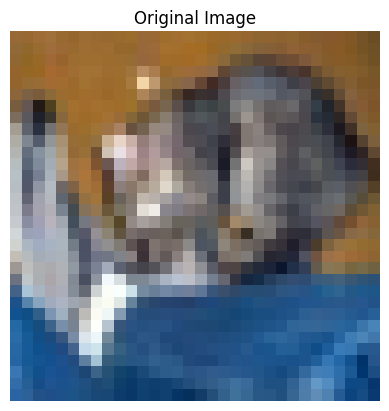

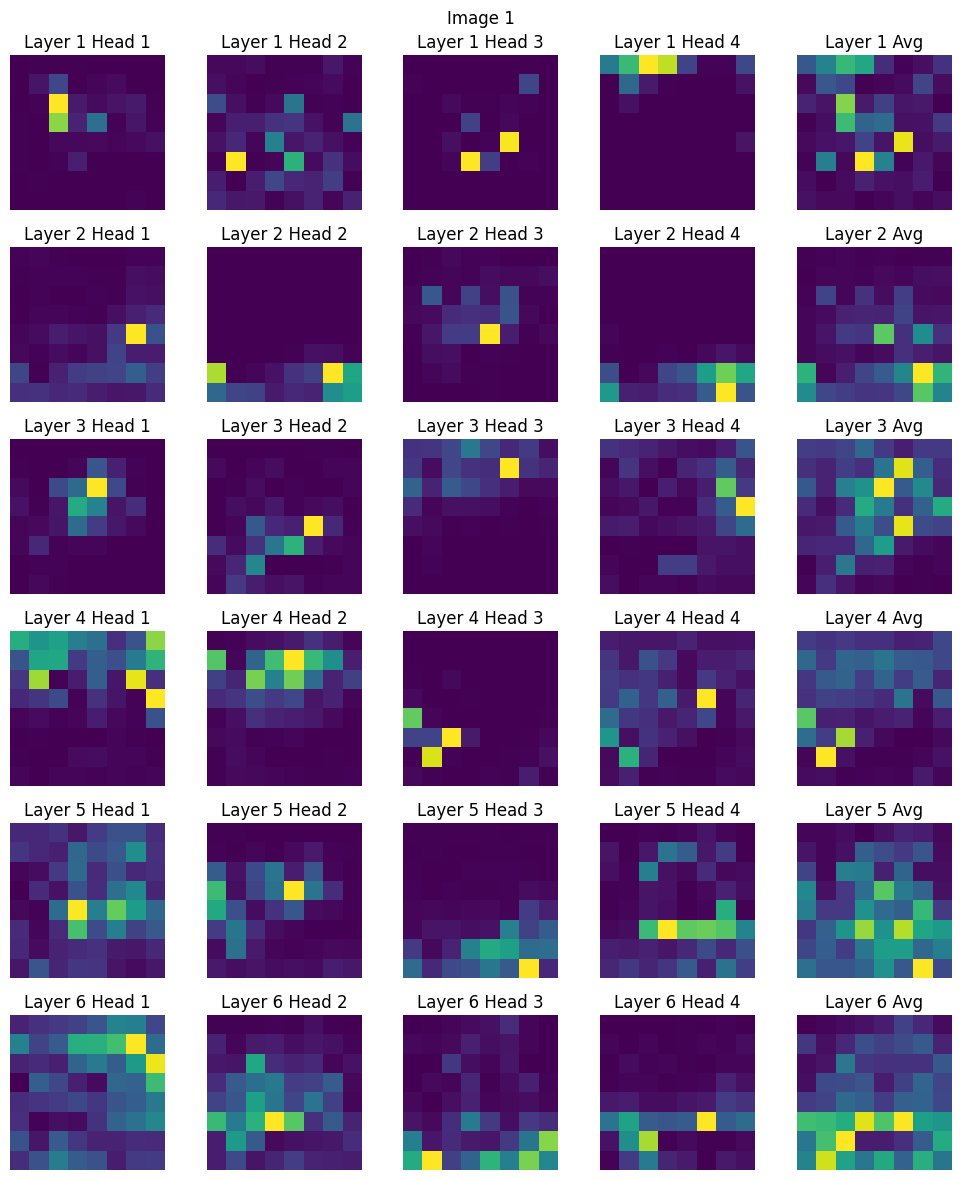

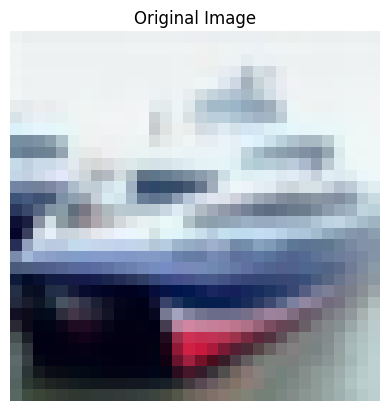

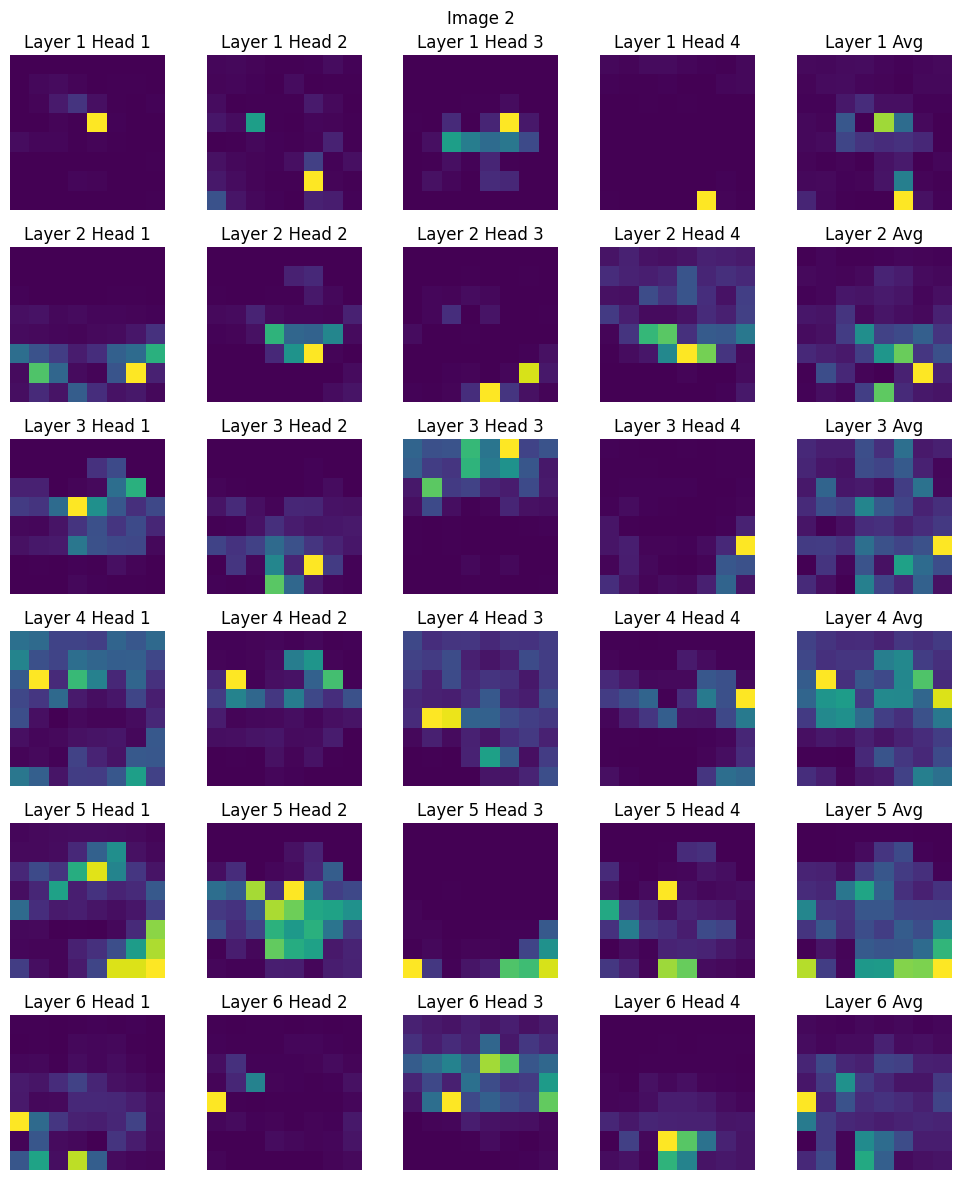

In [27]:
def visualize_attention_maps(model, img, title=""):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # show original image
    img_show = img.permute(1, 2, 0)
    img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())
    plt.imshow(img_show.cpu())
    plt.axis('off')
    plt.title('Original Image')
    plt.show()
    
    img = img.unsqueeze(0).to(device) 

    with torch.no_grad():
        outputs = model(img)
        attention_maps = [encoder.attention_map for encoder in model.transformer_encoder]
    
    # for every layer show attention from CLS to all others for each head as well as the average in one plot
    num_layers = len(attention_maps)
    num_heads = attention_maps[0].size(1)
    fig, axs = plt.subplots(num_layers, num_heads + 1, figsize=(10, 2 * num_layers))
    for i in range(num_layers):
        for j in range(num_heads):
            attn_map = attention_maps[i][:, j, 0, 1:].reshape(1, 1, 8, 8).squeeze(0).cpu().numpy()
            attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())
            attn_map = np.transpose(attn_map, (1, 2, 0))
            axs[i, j].imshow(attn_map)
            axs[i, j].axis('off')
            axs[i, j].set_title(f'Layer {i + 1} Head {j + 1}')
        avg_attn_map = attention_maps[i][:, :, 0, 1:].mean(dim=1).reshape(1, 1, 8, 8).squeeze(0).cpu().numpy()
        
        avg_attn_map = np.transpose(avg_attn_map, (1, 2, 0))
        axs[i, num_heads].imshow(avg_attn_map)
        axs[i, num_heads].axis('off')
        axs[i, num_heads].set_title(f'Layer {i + 1} Avg')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_attention_maps(model, testset[0][0], "Image 1")
visualize_attention_maps(model, testset[1][0], "Image 2")

### Attention Rollout

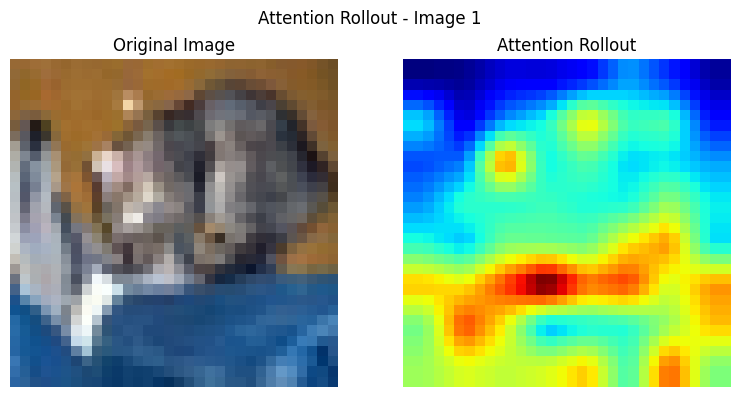

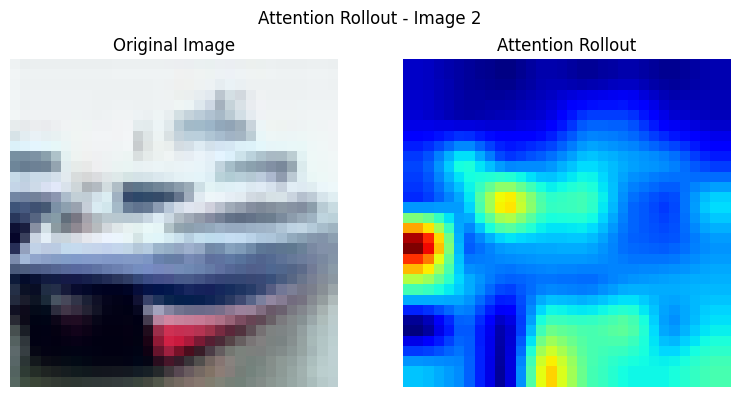

In [ ]:
def compute_attention_rollout(model, img, discard_ratio=0.0):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        attention_maps = [encoder.attention_map for encoder in model.transformer_encoder]

    rollout = torch.eye(attention_maps[0].size(-1)).to(device)

    for attn_map in attention_maps:
        avg_attn = attn_map.mean(dim=1)
        if discard_ratio > 0.0:
            num_tokens = avg_attn.size(-1)
            num_discard = int(discard_ratio * num_tokens)
            avg_attn = avg_attn.clone()
            avg_attn[:, :num_discard] = 0
        avg_attn = avg_attn + torch.eye(avg_attn.size(-1)).to(device)
        avg_attn = avg_attn / avg_attn.sum(dim=-1, keepdim=True)
        rollout = torch.matmul(rollout, avg_attn)

    cls_attn = rollout[0, 0, 1:]  
    cls_attn = cls_attn.reshape(1, 1, int(cls_attn.size(0)**0.5), int(cls_attn.size(0)**0.5))
    cls_attn = torch.nn.functional.interpolate(cls_attn, size=(img.size(2), img.size(3)), mode='bilinear', align_corners=False)
    return cls_attn.squeeze(0).cpu().numpy()

def visualize_attention_rollout(model, img, title=""):
    rollout_map = compute_attention_rollout(model, img)

    rollout_map = (rollout_map - rollout_map.min()) / (rollout_map.max() - rollout_map.min())
    rollout_map = rollout_map.transpose(1, 2, 0)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    img_show = img.permute(1, 2, 0)
    img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())
    axs[0].imshow(img_show.cpu())
    axs[0].axis('off')
    axs[0].set_title('Original Image')
    axs[1].imshow(rollout_map, cmap='jet')
    axs[1].axis('off')
    axs[1].set_title('Attention Rollout')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_attention_rollout(model, testset[0][0], "Attention Rollout - Image 1")
visualize_attention_rollout(model, testset[1][0], "Attention Rollout - Image 2")

### Positional Embedding Visualization

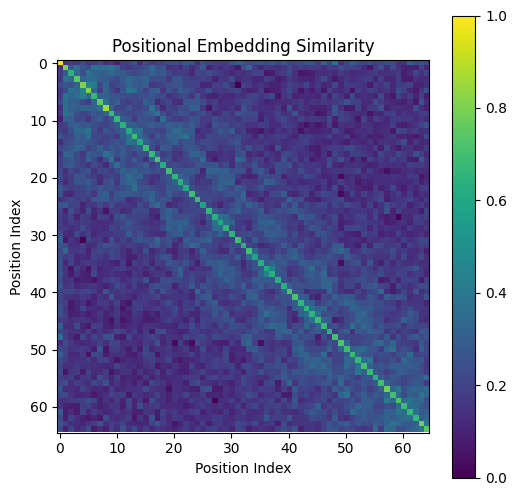

In [27]:
def visualize_positional_embedding_similarity(model, title="Positional Embedding Similarity"):
    pos_embedding = model.position_embedding.squeeze(0).detach().cpu().numpy()
    
    similarity_matrix = np.dot(pos_embedding, pos_embedding.T)
    
    similarity_matrix = (similarity_matrix - similarity_matrix.min()) / (similarity_matrix.max() - similarity_matrix.min())
    
    plt.figure(figsize=(6,6))
    plt.imshow(similarity_matrix, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Position Index")
    plt.ylabel("Position Index")
    plt.show()

visualize_positional_embedding_similarity(model)